# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.
Задача - научиться определять рыночную стоимость объектов недвижимости. Требуется установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

### Подготовка данных

Загрузим нужные библиотеки и прочтем файл

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns

pd.set_option('display.max_columns', None)

import warnings

warnings.filterwarnings('ignore')

In [88]:
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [89]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**Описание данных:**

airports_nearest — расстояние до ближайшего аэропорта в метрах (м) <br>
balcony — число балконов <br>
ceiling_height — высота потолков (м) <br>
cityCenters_nearest — расстояние до центра города (м) <br>
days_exposition — сколько дней было размещено объявление (от публикации до снятия) <br>
first_day_exposition — дата публикации <br>
floor — этаж <br>
floors_total — всего этажей в доме <br>
is_apartment — апартаменты (булев тип) <br>
kitchen_area — площадь кухни в квадратных метрах (м²) <br>
last_price — цена на момент снятия с публикации <br>
living_area — жилая площадь в квадратных метрах (м²) <br>
locality_name — название населённого пункта <br>
open_plan — свободная планировка (булев тип) <br>
parks_around3000 — число парков в радиусе 3 км <br>
parks_nearest — расстояние до ближайшего парка (м) <br>
ponds_around3000 — число водоёмов в радиусе 3 км <br>
ponds_nearest — расстояние до ближайшего водоёма (м) <br>
rooms — число комнат <br>
studio — квартира-студия (булев тип) <br>
total_area — общая площадь квартиры в квадратных метрах (м²) <br>
total_images — число фотографий квартиры в объявлении

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [91]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [92]:
(df.isna().mean()*100).sort_values(ascending=False)

is_apartment            88.290645
parks_nearest           65.909954
ponds_nearest           61.559559
balcony                 48.605426
ceiling_height          38.799105
airports_nearest        23.384953
cityCenters_nearest     23.287902
ponds_around3000        23.283683
parks_around3000        23.283683
days_exposition         13.422507
kitchen_area             9.612220
living_area              8.029875
floors_total             0.362885
locality_name            0.206760
total_images             0.000000
last_price               0.000000
studio                   0.000000
floor                    0.000000
rooms                    0.000000
first_day_exposition     0.000000
total_area               0.000000
open_plan                0.000000
dtype: float64

Проверим количество пропусков

In [93]:
df.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

Построим общую гистограмму для всех столбцов таблицы

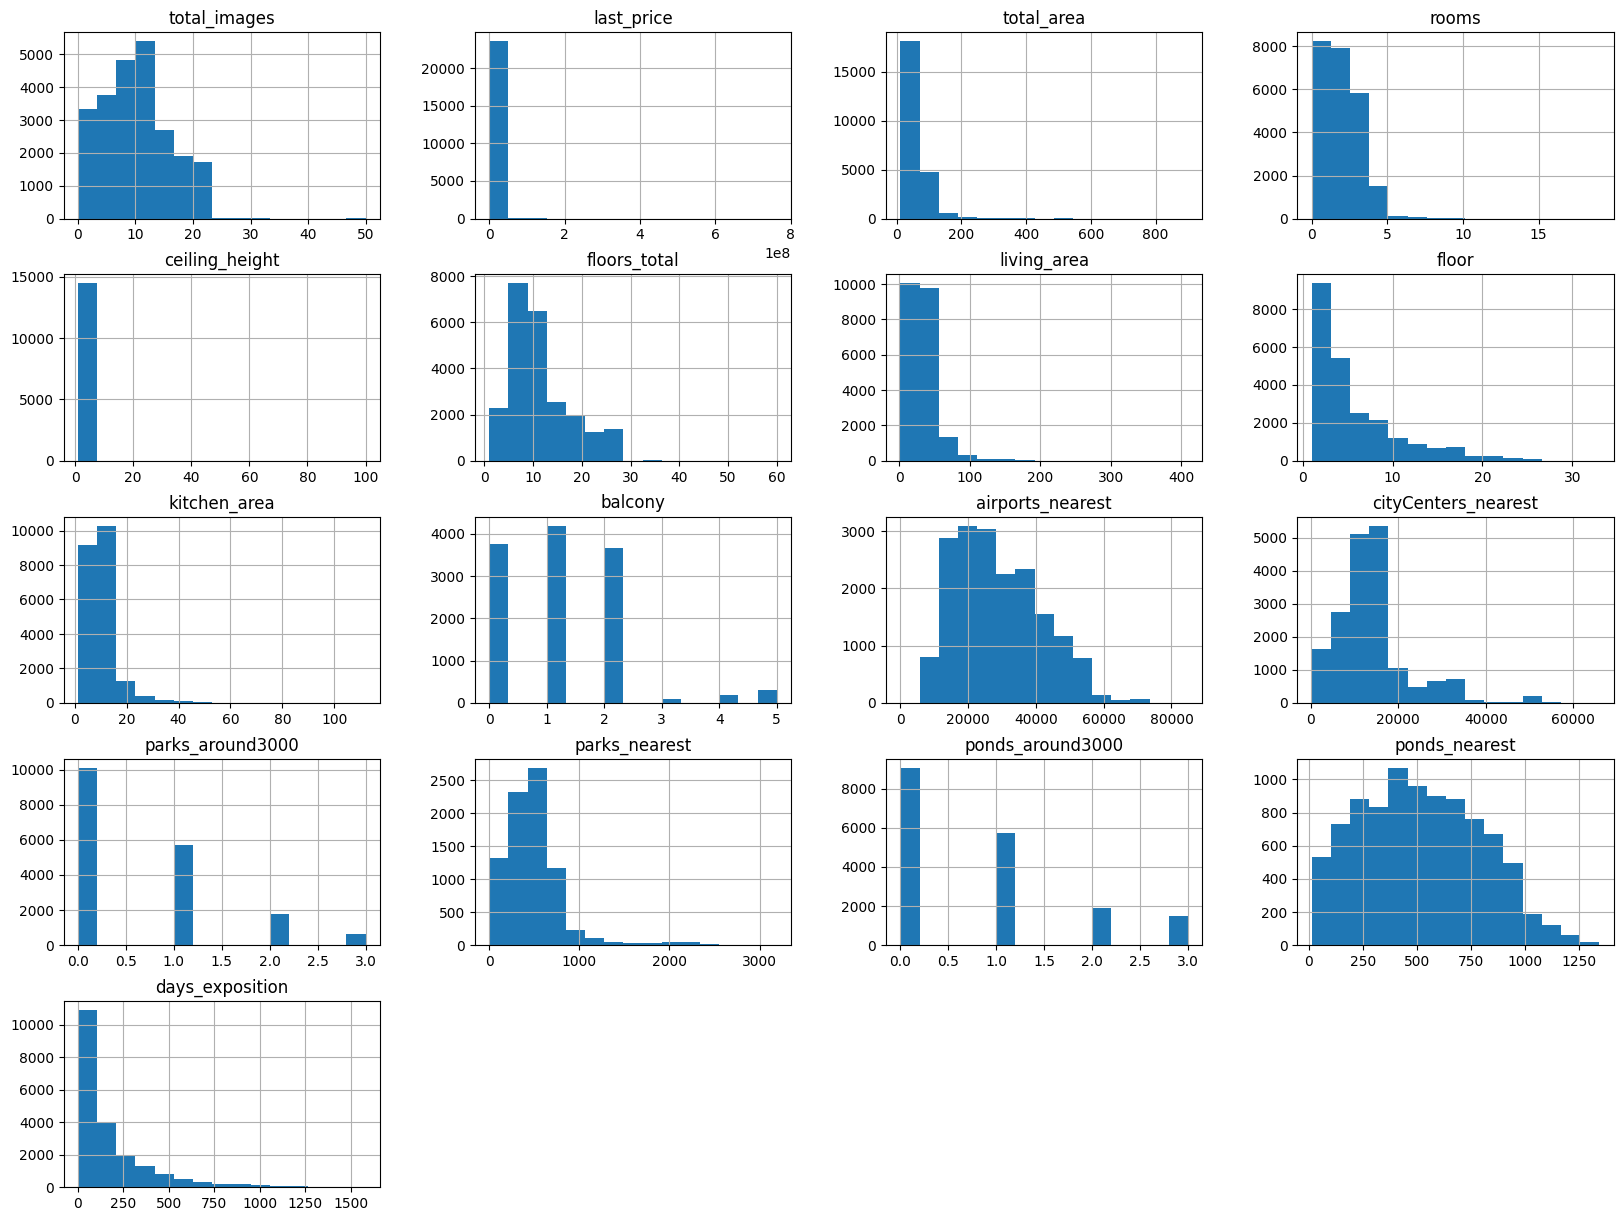

In [94]:
df.hist(bins=15, figsize=(20, 15));

- количество комнат обычно до 5, но встречаются редкие объявления со значениями до 19
- количество объявлений со временем увеличивается
- большинство квартир находится в радиусе 20 км от центра города

Отметим параметры с наиболее сильными правыми выбросами (хвостами):
- цена объекта
- высота потолков
- общая площадь (+ жилая и площадь кухни)
- количество дней размещения
- этаж квартиры

**Выводы после первого знакомства с данными:**
- во многих параметрах присутствуют пропуски и выбросы
- есть аномалии по высоте потолков
- есть аномальные значения в параметре `airports_nearest` - минимальное значение расстония равно 0
- минимальная цена кажется невозможной
- согласно правил размещения объявлений "для всех объявлений обязательны фотографии объекта", а в наборе данных присутствуют объявления без фотографий

### Предобработка данных

#### Проверим дубликаты

Проверим неявные дубликаты

In [95]:
df.locality_name.nunique()

364

In [96]:
df['locality_name'].value_counts().head(50)

Санкт-Петербург                            15721
посёлок Мурино                               522
посёлок Шушары                               440
Всеволожск                                   398
Пушкин                                       369
Колпино                                      338
посёлок Парголово                            327
Гатчина                                      307
деревня Кудрово                              299
Выборг                                       237
Петергоф                                     201
Сестрорецк                                   183
Красное Село                                 178
Кудрово                                      173
деревня Новое Девяткино                      144
Сертолово                                    142
Ломоносов                                    133
Кириши                                       125
Сланцы                                       112
Волхов                                       111
Тосно               

In [97]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е')
df['locality_name'] = df['locality_name'].str.replace('деревня ', '')
df['locality_name'] = df['locality_name'].str.replace('поселок городского типа имени ', '')
df['locality_name'] = df['locality_name'].str.replace('поселок городского типа ', '')
df['locality_name'] = df['locality_name'].str.replace('городской поселок ', '')
df['locality_name'] = df['locality_name'].str.replace('поселок ', '')

In [98]:
df['locality_name'].value_counts().head(50)

Санкт-Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
Пушкин               369
Колпино              338
Парголово            327
Гатчина              307
Выборг               237
Петергоф             201
Сестрорецк           183
Красное Село         178
Новое Девяткино      144
Сертолово            142
Ломоносов            133
Кириши               125
Бугры                114
Сланцы               112
Волхов               111
Кингисепп            104
Тосно                104
Кронштадт             96
Никольское            93
Коммунар              89
Сосновый Бор          87
Кировск               84
Отрадное              80
Янино-1               68
Металлострой          66
Приозерск             66
Старая                64
Шлиссельбург          57
Луга                  56
Тихвин                49
Стрельна              44
Тельмана              41
Рощино                39
Павловск              38
Свердлова             36


In [99]:
df['locality_name'].sort_values()

10574          Агалатово
1151           Агалатово
4307           Агалатово
4466           Агалатово
20481    Александровская
              ...       
21898                NaN
22474                NaN
22717                NaN
22933                NaN
23214                NaN
Name: locality_name, Length: 23699, dtype: object

In [100]:
# check
df.locality_name.nunique()

313

In [101]:
# check
df.locality_name.unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Федоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'садовое товарищество Новая Ропша', 'Павловск',
       'Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск',
       'Сестрорецк', 'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое',
       'Заклинье', 'Торковичи', 'Первомайское', 'Красное Село',
       'Понтонный', 'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет',
       'Сланцы', 'село Путилово', 'Ивангород', 'Шлиссельбург',
       'Никольское', 'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино',
       'Романовка', 'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово',
       'Отрадное', 'село Павлово', 'Оредеж', 'село Копорье', 'Молодежное',
       'Тихвин', 'Победа', 'Нурма', 'Синявино', 

In [102]:
df.duplicated().sum()

0

#### Проверим пропуски

In [103]:
df.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [104]:
df_info = pd.DataFrame(df.dtypes).T.rename(index={0:'type'})
df_info = df_info.append(pd.DataFrame(df.isna().sum()).T.rename(index={0:'null values'}))
df_info = df_info.append(pd.DataFrame((df.isna().sum()/df.shape[0])*100).T.rename(index={0:'null values (%)'}))
df_info.T.sort_values(by='null values (%)', ascending=False)

,type,null values,null values (%)
is_apartment,object,20924,88.290645
parks_nearest,float64,15620,65.909954
ponds_nearest,float64,14589,61.559559
balcony,float64,11519,48.605426
ceiling_height,float64,9195,38.799105
airports_nearest,float64,5542,23.384953
cityCenters_nearest,float64,5519,23.287902
ponds_around3000,float64,5518,23.283683
parks_around3000,float64,5518,23.283683
days_exposition,float64,3181,13.422507


<Axes: >

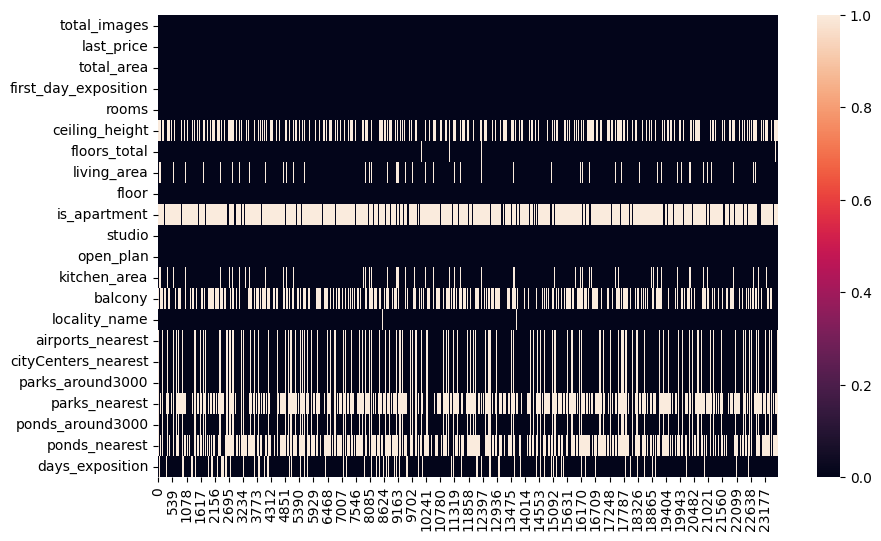

In [105]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose())

В наборе данных достаточно много пропусков.
Их причиной может быть необязательные для заполнения поля, то есть при размещении объявления продавец сам решает, какие параметры важны и какие нужно указывать. Кроме того, период анализа набора данных - 6 лет, высока вероятность внесения изменений в правила размещения объявлений.

При этом много пропусков среди картографических типов данных. Пропуски преобладают именно в этих типах данных. Возможная причина - незаполнение продавцом точного адреса квартиры в объявлении. Также стоит проверить пропуски в этих параметрах с течением времени (по годам).

Предположим, что пропуски в столбце с количеством дней размещения (14% данных) - это активные объявления, то есть квартиры ещё не проданы.

Количество пропущенных значений в `is_apartment`, `parks_nearest` и `ponds_nearest` слишком велико. Логичную замену в них предложить невозможно и заполнение пропусков в них может исказить данные. Принимаем решение избавиться от этих столбцов.

In [106]:
# пропущенные значения бары
def pass_value_bar(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns={0:'space'})
            .query('space > 0')
            .sort_values(by='space')
            .plot(kind='barh', figsize=(19,6), fontsize=16, legend=False)
            .set_title('Распределение пропусков', fontsize=16)
        );
    except:
        print('Пропусков не осталось или произошла ошибка в первой части функции')

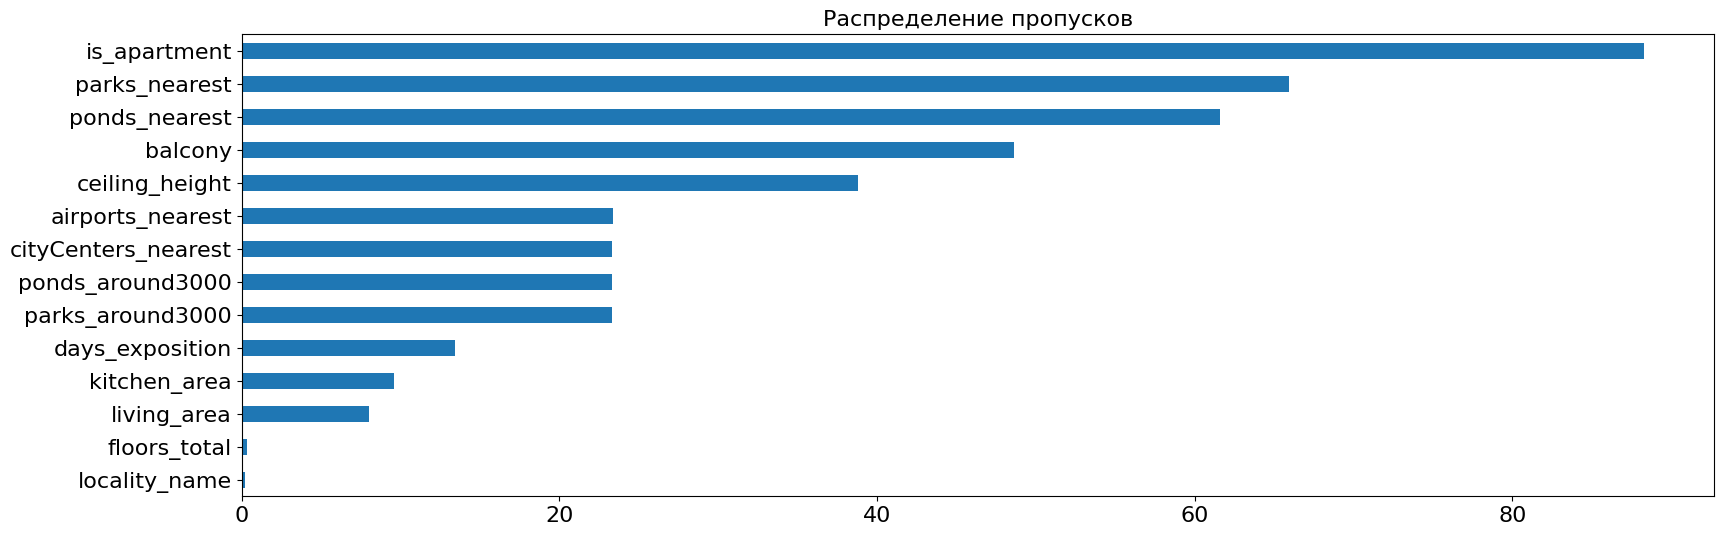

In [107]:
pass_value_bar(df)

In [108]:
df = df.drop(['is_apartment', 'parks_nearest', 'ponds_nearest'], axis=1)
len(df.columns)

19

In [109]:
df.isna().sum().sort_values(ascending=False)

balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
open_plan                   0
last_price                  0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
studio                      0
dtype: int64

Если продавец не указал число балконов, то, скорее всего, в его квартире их нет. Заменим такие пропуски на 0.

In [110]:
df['balcony'] = df['balcony'].fillna(0)

Далее изучим распределение пропусков в `city_сenters_nearest` по городам

In [111]:
df[df['cityCenters_nearest'].isna()]['locality_name'].value_counts().head(10)

Мурино             588
Кудрово            472
Всеволожск         398
Гатчина            307
Выборг             237
Новое Девяткино    144
Сертолово          142
Кириши             125
Бугры              114
Сланцы             112
Name: locality_name, dtype: int64

In [112]:
df['locality_name'].value_counts().head(10)

Санкт-Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
Пушкин               369
Колпино              338
Парголово            327
Гатчина              307
Выборг               237
Name: locality_name, dtype: int64

Мы видим, что пропуски преобладают в Ленинградской области. Для дальнейшего анализа значений параметра наименования населенного пункта будет достаточно. Но некоторые пропуски в `airports_nearest` и в `cityCenters_nearest` можно заполнить медианным значением по наименованиям населенного пункта.

In [113]:
for t in df['locality_name'].unique():
    df.loc[(df['locality_name'] == t) & (df['airports_nearest'].isna()), 'airports_nearest'] = \
    df.loc[(df['locality_name'] == t), 'airports_nearest'].median()

In [114]:
for t in df['locality_name'].unique():
    df.loc[(df['locality_name'] == t) & (df['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    df.loc[(df['locality_name'] == t), 'cityCenters_nearest'].median()

In [115]:
df.isna().sum().sort_values(ascending=False)

ceiling_height          9195
ponds_around3000        5518
parks_around3000        5518
cityCenters_nearest     4837
airports_nearest        4837
days_exposition         3181
kitchen_area            2278
living_area             1903
floors_total              86
locality_name             49
balcony                    0
total_images               0
open_plan                  0
last_price                 0
floor                      0
rooms                      0
first_day_exposition       0
total_area                 0
studio                     0
dtype: int64

Далее заполним пропуски высоты потолков. Есть предположение, что на высоту потолков в большей степени влияет местоположение квартиры - в исторической части города потолки выше.
Проверим теорию, что высота потолков в квартирах с максимальной близостью к центру выше.

In [116]:
df['cityCenters_nearest_cat'] = pd.qcut(df['cityCenters_nearest'], q=10)

In [117]:
df.groupby('cityCenters_nearest_cat')['ceiling_height'].mean()

cityCenters_nearest_cat
(180.999, 4823.0]     3.211821
(4823.0, 8080.0]      2.995259
(8080.0, 10713.2]     2.866756
(10713.2, 12063.4]    2.680682
(12063.4, 13266.0]    2.689655
(13266.0, 14673.0]    2.673873
(14673.0, 15949.1]    2.683410
(15949.1, 18194.0]    2.630550
(18194.0, 25796.0]    2.747452
(25796.0, 65968.0]    2.679195
Name: ceiling_height, dtype: float64

Да, мы видим, что у ближайших к центру квартир потолки выше. Заменим пропуски в `ceiling_height` медианным значением по параметру отдаленности от центра города

In [118]:
for t in df['cityCenters_nearest_cat'].unique():
    df.loc[(df['cityCenters_nearest_cat'] == t) & (df['ceiling_height'].isna()), 'ceiling_height'] = \
    df.loc[(df['cityCenters_nearest_cat'] == t), 'ceiling_height'].median()

In [119]:
df.isna().sum().sort_values(ascending=False)

ponds_around3000           5518
parks_around3000           5518
cityCenters_nearest_cat    4837
cityCenters_nearest        4837
airports_nearest           4837
days_exposition            3181
kitchen_area               2278
ceiling_height             2164
living_area                1903
floors_total                 86
locality_name                49
balcony                       0
total_images                  0
last_price                    0
studio                        0
floor                         0
rooms                         0
first_day_exposition          0
total_area                    0
open_plan                     0
dtype: int64

Оставшиеся значения заменим медианой по населенным пунктам

In [120]:
for t in df['locality_name'].unique():
    df.loc[(df['locality_name'] == t) & (df['ceiling_height'].isna()), 'ceiling_height'] = \
    df.loc[(df['locality_name'] == t), 'ceiling_height'].median()

In [121]:
df.isna().sum().sort_values(ascending=False)

ponds_around3000           5518
parks_around3000           5518
cityCenters_nearest_cat    4837
cityCenters_nearest        4837
airports_nearest           4837
days_exposition            3181
kitchen_area               2278
living_area                1903
ceiling_height               99
floors_total                 86
locality_name                49
balcony                       0
total_images                  0
last_price                    0
studio                        0
floor                         0
rooms                         0
first_day_exposition          0
total_area                    0
open_plan                     0
dtype: int64

Пропуски в `days_exposition` говорят нам, что квартиры ещё не проданы, это важный признак, оставляем пропуски

Пропуски площади кухни и жилой площади заполним средним их соотношением к общей площади

In [122]:
print((df['total_area'] / df['living_area']).mean())
print((df['total_area'] / df['kitchen_area']).mean())

1.8464700489680814
6.133493274864257


In [123]:
df['living_area'] = df['living_area'].fillna(df['total_area'] / (df['total_area'] / df['living_area']).mean())
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area'] / (df['total_area'] / df['kitchen_area']).mean())

После такого заполнения проверим данные на аномалии

In [124]:
df[(df['total_area']*0.9 <= (df['living_area'] + df['kitchen_area']))]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition,cityCenters_nearest_cat
41,16,7900000.0,74.0,2016-05-04T00:00:00,3,2.60,14.0,59.00,8,False,False,12.000000,5.0,Санкт-Петербург,37715.0,12612.0,1.0,1.0,179.0,"(12063.4, 13266.0]"
171,6,3800000.0,49.0,2019-02-22T00:00:00,2,2.50,9.0,38.00,8,False,False,10.000000,1.0,Шушары,18471.0,24272.0,0.0,0.0,11.0,"(18194.0, 25796.0]"
184,7,2600000.0,30.2,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,False,False,6.200000,0.0,Санкт-Петербург,13952.0,15031.0,0.0,1.0,12.0,"(14673.0, 15949.1]"
220,8,3890000.0,37.0,2018-07-09T00:00:00,1,2.50,25.0,28.00,6,False,False,9.000000,0.0,Санкт-Петербург,25408.0,16166.0,0.0,0.0,28.0,"(15949.1, 18194.0]"
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,2.60,NaN,20.75,1,False,False,4.581402,0.0,Санкт-Петербург,22041.0,17369.0,0.0,1.0,251.0,"(15949.1, 18194.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23216,15,10150000.0,114.0,2015-01-21T00:00:00,4,3.00,5.0,90.20,4,False,False,16.000000,0.0,Санкт-Петербург,26259.0,4961.0,0.0,2.0,1052.0,"(4823.0, 8080.0]"
23297,10,1850000.0,48.2,2019-03-13T00:00:00,2,2.50,5.0,42.20,2,False,False,6.000000,1.0,Высоцк,NaN,NaN,NaN,NaN,45.0,NaN
23328,12,4299000.0,54.0,2016-11-25T00:00:00,2,2.60,14.0,40.00,8,False,False,10.000000,0.0,Колпино,25612.0,31399.0,0.0,0.0,343.0,"(25796.0, 65968.0]"
23521,13,8500000.0,65.0,2018-11-01T00:00:00,2,3.10,4.0,44.00,2,False,False,15.300000,0.0,Санкт-Петербург,22276.0,3996.0,1.0,0.0,NaN,"(180.999, 4823.0]"


In [125]:
df.loc[(df['total_area']*0.9 <= (df['living_area'] + df['kitchen_area'])), 'living_area'] = \
    df['living_area']*0.7

In [126]:
df.loc[(df['total_area']*0.9 <= (df['living_area'] + df['kitchen_area'])), 'kitchen_area'] = \
    df['kitchen_area']*0.7

In [127]:
df = df[~(df['total_area']*0.9 <= (df['living_area'] + df['kitchen_area']))]

Пропуски в единственной строке с типом object заменим на строку 'no info'

In [128]:
df['locality_name'] = df['locality_name'].fillna('no info')

In [129]:
df.isna().sum().sort_values(ascending=False)

ponds_around3000           5516
parks_around3000           5516
cityCenters_nearest_cat    4836
cityCenters_nearest        4836
airports_nearest           4836
days_exposition            3180
ceiling_height               99
floors_total                 86
kitchen_area                  0
locality_name                 0
balcony                       0
total_images                  0
last_price                    0
studio                        0
floor                         0
living_area                   0
rooms                         0
first_day_exposition          0
total_area                    0
open_plan                     0
dtype: int64

Таким образом, мы заполнили пропуски в наиболее важных для анализа столбцах

#### Проверим типы данных

In [130]:
df.dtypes

total_images                  int64
last_price                  float64
total_area                  float64
first_day_exposition         object
rooms                         int64
ceiling_height              float64
floors_total                float64
living_area                 float64
floor                         int64
studio                         bool
open_plan                      bool
kitchen_area                float64
balcony                     float64
locality_name                object
airports_nearest            float64
cityCenters_nearest         float64
parks_around3000            float64
ponds_around3000            float64
days_exposition             float64
cityCenters_nearest_cat    category
dtype: object

Приведём столбец `first_day_exposition` к типу данных даты и времени. Это потребуется нам для отслеживания динамики и возможности извлечения конкретного года. Время в данных не указано, его можно отбросить.

Столбцы `days_exposition`, `floors_total`, `parks_around3000` лучше было бы перевести из float64 в int64, но там есть пропуски.

In [131]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])
df['balcony'] = df['balcony'].astype(int)

In [132]:
print('Начальная дата в наборе данных: ', df.first_day_exposition.min())
print('Конечная дата в наборе данных: ', df.first_day_exposition.max())

Начальная дата в наборе данных:  2014-11-27 00:00:00
Конечная дата в наборе данных:  2019-05-03 00:00:00


#### Редкие и выбивающиеся значения

Проверим, нет ли аномальных строк, в которых номер этажа больше общего количества этажей в доме

In [133]:
df[df['floor'] > df['floors_total']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition,cityCenters_nearest_cat


Всё хорошо, таких строк нет

In [134]:
df['rooms'].max()

19

In [135]:
df['ceiling_height'].max()

100.0

Вероятность квартиры с высотой потолков 100 метров крайне мала. Скорее всего, здесь ошибка в формате заведения данных. Поработаем с этим столбцом.

In [136]:
df['ceiling_height'].describe()

count    23591.000000
mean         2.736847
std          1.007733
min          1.000000
25%          2.560000
50%          2.600000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

In [137]:
df['ceiling_height'].sort_values(ascending=False).head(30)

22869    100.0
22336     32.0
3148      32.0
21377     27.5
10773     27.0
20478     27.0
17857     27.0
21824     27.0
22938     27.0
4876      27.0
2158      27.0
5246      27.0
5807      27.0
5669      26.0
11285     25.0
14382     25.0
6246      25.0
18545     25.0
4643      25.0
355       25.0
9379      25.0
5076      24.0
20507     22.6
17496     20.0
15061     14.0
22309     10.3
5863       8.3
17442      8.0
3474       8.0
15743      8.0
Name: ceiling_height, dtype: float64

In [138]:
df.loc[df['ceiling_height'] > 18.0, 'ceiling_height'] = df['ceiling_height']*0.1

In [139]:
df = df[~(df['ceiling_height'] < 1.6)]

In [140]:
df['ceiling_height'].sort_values(ascending=False).head()

15061    14.0
22309    10.3
22869    10.0
5863      8.3
15743     8.0
Name: ceiling_height, dtype: float64

In [141]:
df[df['floors_total'] == df['floors_total'].max()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition,cityCenters_nearest_cat
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60.0,27.4,4,False,False,7.4,0,Кронштадт,67763.0,49488.0,2.0,3.0,166.0,"(25796.0, 65968.0]"


In [142]:
df = df[~(df['airports_nearest']==0)]

In [143]:
# check
data = df.copy()

In [144]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23687 entries, 0 to 23698
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23687 non-null  int64         
 1   last_price               23687 non-null  float64       
 2   total_area               23687 non-null  float64       
 3   first_day_exposition     23687 non-null  datetime64[ns]
 4   rooms                    23687 non-null  int64         
 5   ceiling_height           23588 non-null  float64       
 6   floors_total             23601 non-null  float64       
 7   living_area              23687 non-null  float64       
 8   floor                    23687 non-null  int64         
 9   studio                   23687 non-null  bool          
 10  open_plan                23687 non-null  bool          
 11  kitchen_area             23687 non-null  float64       
 12  balcony                  23687 n

In [145]:
df = df.dropna(subset=['floors_total'])

In [146]:
df['floors_total'] = df['floors_total'].astype(int)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23601 entries, 0 to 23698
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23601 non-null  int64         
 1   last_price               23601 non-null  float64       
 2   total_area               23601 non-null  float64       
 3   first_day_exposition     23601 non-null  datetime64[ns]
 4   rooms                    23601 non-null  int64         
 5   ceiling_height           23502 non-null  float64       
 6   floors_total             23601 non-null  int64         
 7   living_area              23601 non-null  float64       
 8   floor                    23601 non-null  int64         
 9   studio                   23601 non-null  bool          
 10  open_plan                23601 non-null  bool          
 11  kitchen_area             23601 non-null  float64       
 12  balcony                  23601 n

Выведем основные параметры для анализа и проверим оставшиеся аномалии

In [148]:
# check
df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']].apply (['count', 'min', 'max', 'median'])

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,23601.0,23601.0,23502.00,20430.0,23601.0,23601.0,23601.0,23601.0,23601.0
min,0.0,12.0,1.75,1.0,12190.0,2.0,1.3,1.0,1.0
max,19.0,900.0,14.00,1580.0,763000000.0,409.7,112.0,33.0,60.0
median,2.0,52.0,2.60,95.0,4650000.0,30.0,9.0,4.0,9.0


Остались аномалии и редкости (в т.ч. и хвосты) в колонках:
    'rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floors_total'

In [149]:
df = df[~((df['studio'] == True) & (df['rooms'] != 0) & (df['total_area'] < 30))]

In [150]:
df.sort_values(by='living_area').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition,cityCenters_nearest_cat
21758,0,2330000.0,23.0,2018-01-01,0,2.65,24,2.0,22,True,False,3.749902,0,Мурино,51553.0,21888.0,NaN,NaN,66.0,"(18194.0, 25796.0]"
13915,20,6350000.0,52.0,2018-02-06,2,3.00,6,2.0,2,False,False,9.000000,0,Санкт-Петербург,32453.0,6521.0,0.0,1.0,91.0,"(4823.0, 8080.0]"
23574,14,64990000.0,139.0,2015-11-24,3,3.00,8,3.0,8,False,False,16.000000,1,Санкт-Петербург,33255.0,5975.0,1.0,3.0,280.0,"(4823.0, 8080.0]"
3242,7,4440000.0,41.0,2017-07-02,1,2.60,17,3.0,17,False,False,11.000000,0,Санкт-Петербург,19272.0,13073.0,0.0,0.0,216.0,"(12063.4, 13266.0]"
17582,11,2680000.0,22.0,2018-08-11,0,2.60,25,5.0,8,True,False,3.586863,2,Санкт-Петербург,22735.0,11618.0,1.0,1.0,70.0,"(10713.2, 12063.4]"
21943,15,6100000.0,77.6,2019-02-28,4,2.50,9,5.4,1,False,False,9.800000,0,Санкт-Петербург,29338.0,11270.0,1.0,0.0,33.0,"(10713.2, 12063.4]"
16431,13,3799000.0,31.0,2018-04-12,1,2.60,5,6.0,1,False,False,17.000000,0,Санкт-Петербург,32177.0,4826.0,1.0,0.0,168.0,"(4823.0, 8080.0]"
7312,8,3400000.0,27.0,2018-02-21,2,2.50,15,6.3,4,False,False,16.000000,0,Санкт-Петербург,50246.0,16444.0,1.0,0.0,NaN,"(15949.1, 18194.0]"
19251,19,4050000.0,33.0,2018-10-15,1,2.50,22,6.5,21,False,False,18.000000,0,Санкт-Петербург,9258.0,10592.0,1.0,0.0,44.0,"(8080.0, 10713.2]"
19807,0,3800000.0,13.0,2018-07-04,1,3.10,5,7.0,3,False,False,2.119510,0,Санкт-Петербург,21302.0,1242.0,1.0,3.0,9.0,"(180.999, 4823.0]"


Первые 9 строк выглядят неправдоподобно, избавимся от них

In [151]:
df = df[~(df['living_area'] < 7)]

In [152]:
df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']].apply(['count', 'min', 'max', 'median'])

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,23585.0,23585.0,23486.00,20415.0,23585.0,23585.0,23585.0,23585.0,23585.0
min,0.0,12.0,1.75,1.0,12190.0,7.0,1.3,1.0,1.0
max,19.0,900.0,14.00,1580.0,763000000.0,409.7,112.0,33.0,60.0
median,2.0,52.0,2.60,95.0,4650000.0,30.0,9.0,4.0,9.0


In [153]:
(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',
        'kitchen_area', 'floor', 'floors_total']]
    .quantile([0, 0.0012, 0.01, .5, .99, .9988, 1]) # выбираем размах в 0,9976 квантилей
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0000,0.0,12.000,1.75,1.000,12190.0,7.000000,1.300000,1.0,1.0
0.0012,0.0,20.000,2.40,3.000,561504.0,9.763873,3.000000,1.0,2.0
0.0100,1.0,25.500,2.50,4.000,1000000.0,12.600000,4.129001,1.0,2.0
0.5000,2.0,52.000,2.60,95.000,4650000.0,30.000000,9.000000,4.0,9.0
0.9900,5.0,197.312,3.60,1067.000,36000000.0,117.400000,35.358000,23.0,26.0
0.9988,8.0,380.000,4.40,1370.516,124843584.0,219.398400,62.349600,26.0,35.0
1.0000,19.0,900.000,14.00,1580.000,763000000.0,409.700000,112.000000,33.0,60.0


Избавимся от выбросов по основным столбцам

In [154]:
len(df)

23585

Экспертно определим выбросы

1.75
14.0
2.5
3.642699999999968
2.6


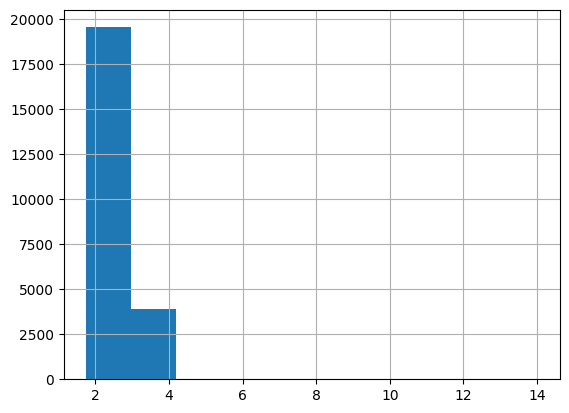

In [155]:
df['ceiling_height'].hist()
print(df['ceiling_height'].min())
print(df['ceiling_height'].max())
print(df['ceiling_height'].quantile(0.012))
print(df['ceiling_height'].quantile(0.991))
print(df['ceiling_height'].median())

0
19
5.0
2.0


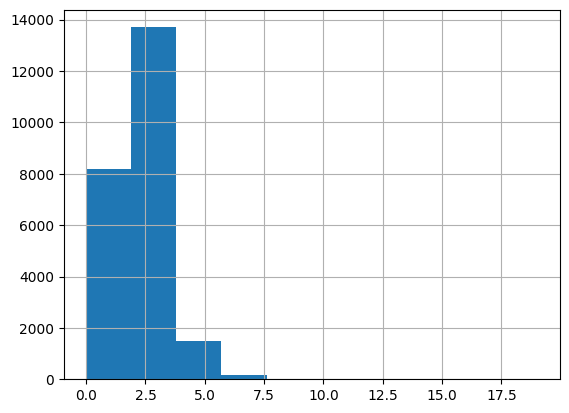

In [156]:
df['rooms'].hist()
print(df['rooms'].min())
print(df['rooms'].max())
print(df['rooms'].quantile(0.991))
print(df['rooms'].median())

12.0
900.0
18.56768
190.0
52.0


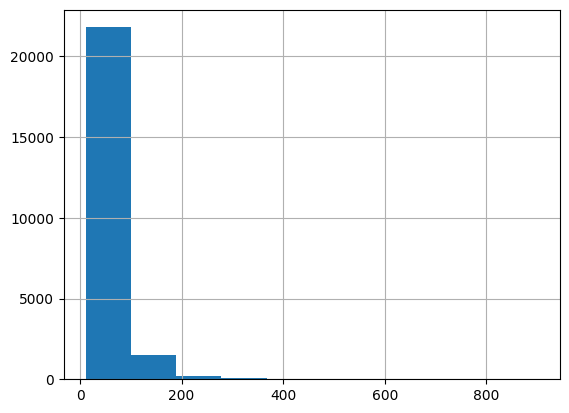

In [157]:
df['total_area'].hist()
print(df['total_area'].min())
print(df['total_area'].max())
print(df['total_area'].quantile(0.0009))
print(df['total_area'].quantile(0.989))
print(df['total_area'].median())

12190.0
763000000.0
800000.0
20000000.0
4650000.0


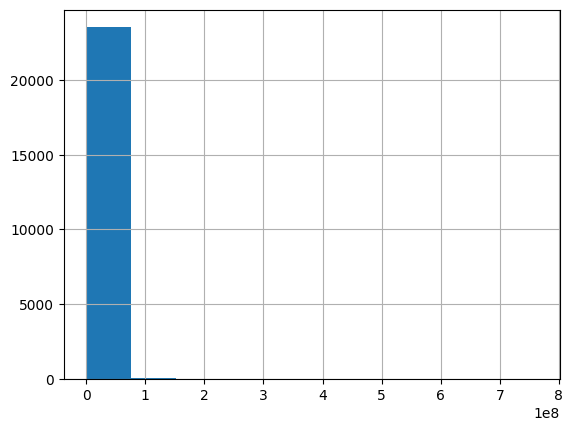

In [158]:
df['last_price'].hist()
print(df['last_price'].min())
print(df['last_price'].max())
print(df['last_price'].quantile(0.005))
print(df['last_price'].quantile(0.97))
print(df['last_price'].median())

<Axes: >

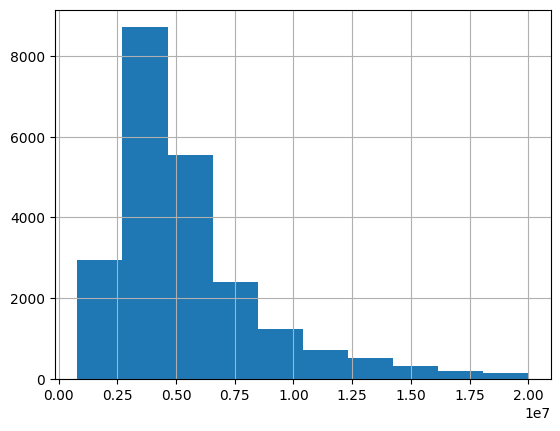

In [159]:
df['last_price'].hist(range=(800000, 20000000))

1.3
112.0
35.358
9.0


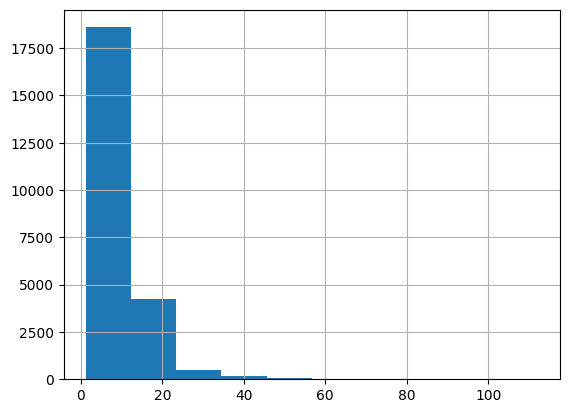

In [160]:
df['kitchen_area'].hist()
print(df['kitchen_area'].min())
print(df['kitchen_area'].max())
print(df['kitchen_area'].quantile(0.99))
print(df['kitchen_area'].median())

1
60
28.0
9.0


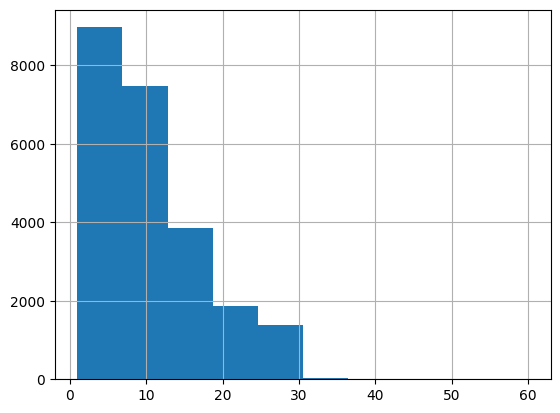

In [161]:
df['floors_total'].hist()
print(df['floors_total'].min())
print(df['floors_total'].max())
print(df['floors_total'].quantile(0.9985))
print(df['floors_total'].median())

7.0
409.7
102.0
30.0


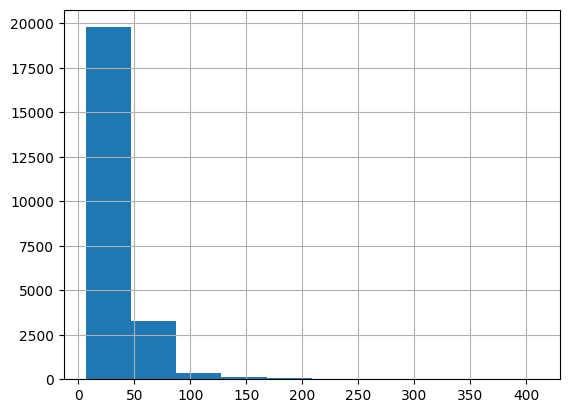

In [162]:
df['living_area'].hist()
print(df['living_area'].min())
print(df['living_area'].max())
print(df['living_area'].quantile(0.985))
print(df['living_area'].median())

1
33
23.0
4.0


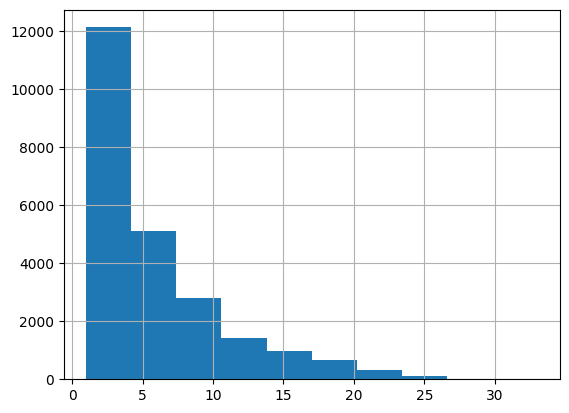

In [163]:
df['floor'].hist()
print(df['floor'].min())
print(df['floor'].max())
print(df['floor'].quantile(0.99))
print(df['floor'].median())

1.0
1580.0
3.0000000000000004
789.5799999999981
95.0


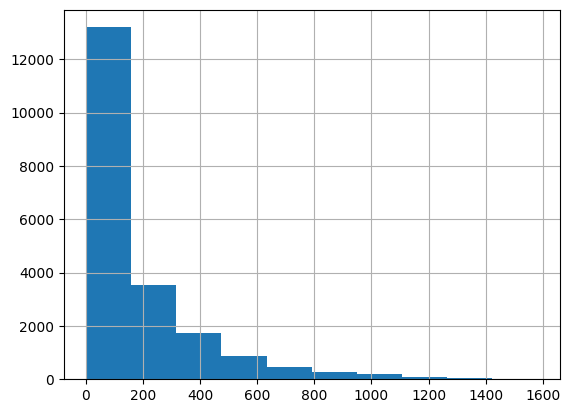

In [164]:
df['days_exposition'].hist()
print(df['days_exposition'].min())
print(df['days_exposition'].max())
print(df['days_exposition'].quantile(0.0012))
print(df['days_exposition'].quantile(0.97))
print(df['days_exposition'].median())

In [165]:
df_copy = df[(
    (df['rooms'] < df['rooms'].quantile(0.991)) &
    (df['total_area'] > df['total_area'].quantile(0.0009)) & (df['total_area'] < df['total_area'].quantile(0.989)) &
    ((df['ceiling_height'] > df['ceiling_height'].quantile(0.0012)) & (df['ceiling_height'] < df['ceiling_height'].quantile(0.991))) &
    (df['last_price'] > df['last_price'].quantile(0.005)) & (df['last_price'] < df['last_price'].quantile(0.97)) &
    (df['kitchen_area'] < df['kitchen_area'].quantile(0.99)) &
    (df['floors_total'] < df['floors_total'].quantile(0.9985)) &
    (df['living_area'] < df['living_area'].quantile(0.985)) &
    (df['floor'] < df['floor'].quantile(0.99)) &
    ((df['days_exposition'].isna()) | (df['days_exposition'] > df['days_exposition'].quantile(0.0012)) & (df['days_exposition'] < df['days_exposition'].quantile(0.985)))
)]

In [166]:
len(df_copy) / len(df)

0.9046003815984736

In [167]:
(
    df_copy[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',
        'kitchen_area', 'floor', 'floors_total']]
    .quantile([0, 0.0012, 0.01, .5, .99, .9988, 1]) # выбираем размах в 0,9976 квантилей
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0000,0.0,18.800,2.40,4.0000,8.200000e+05,8.00000,1.300000,1.0,1.0
0.0012,0.0,21.400,2.48,4.0000,8.760080e+05,10.00000,3.325416,1.0,2.0
0.0100,1.0,26.000,2.50,5.0000,1.200000e+06,12.60000,4.200000,1.0,2.0
0.5000,2.0,50.300,2.60,92.0000,4.500000e+06,29.50000,9.000000,4.0,9.0
0.9900,4.0,120.664,3.35,843.0000,1.600000e+07,73.40000,25.000000,21.0,26.0
0.9988,4.0,155.000,3.60,956.7088,1.922822e+07,92.03992,33.000000,22.0,27.0
1.0000,4.0,185.000,3.63,972.0000,1.999900e+07,100.40000,35.000000,22.0,27.0


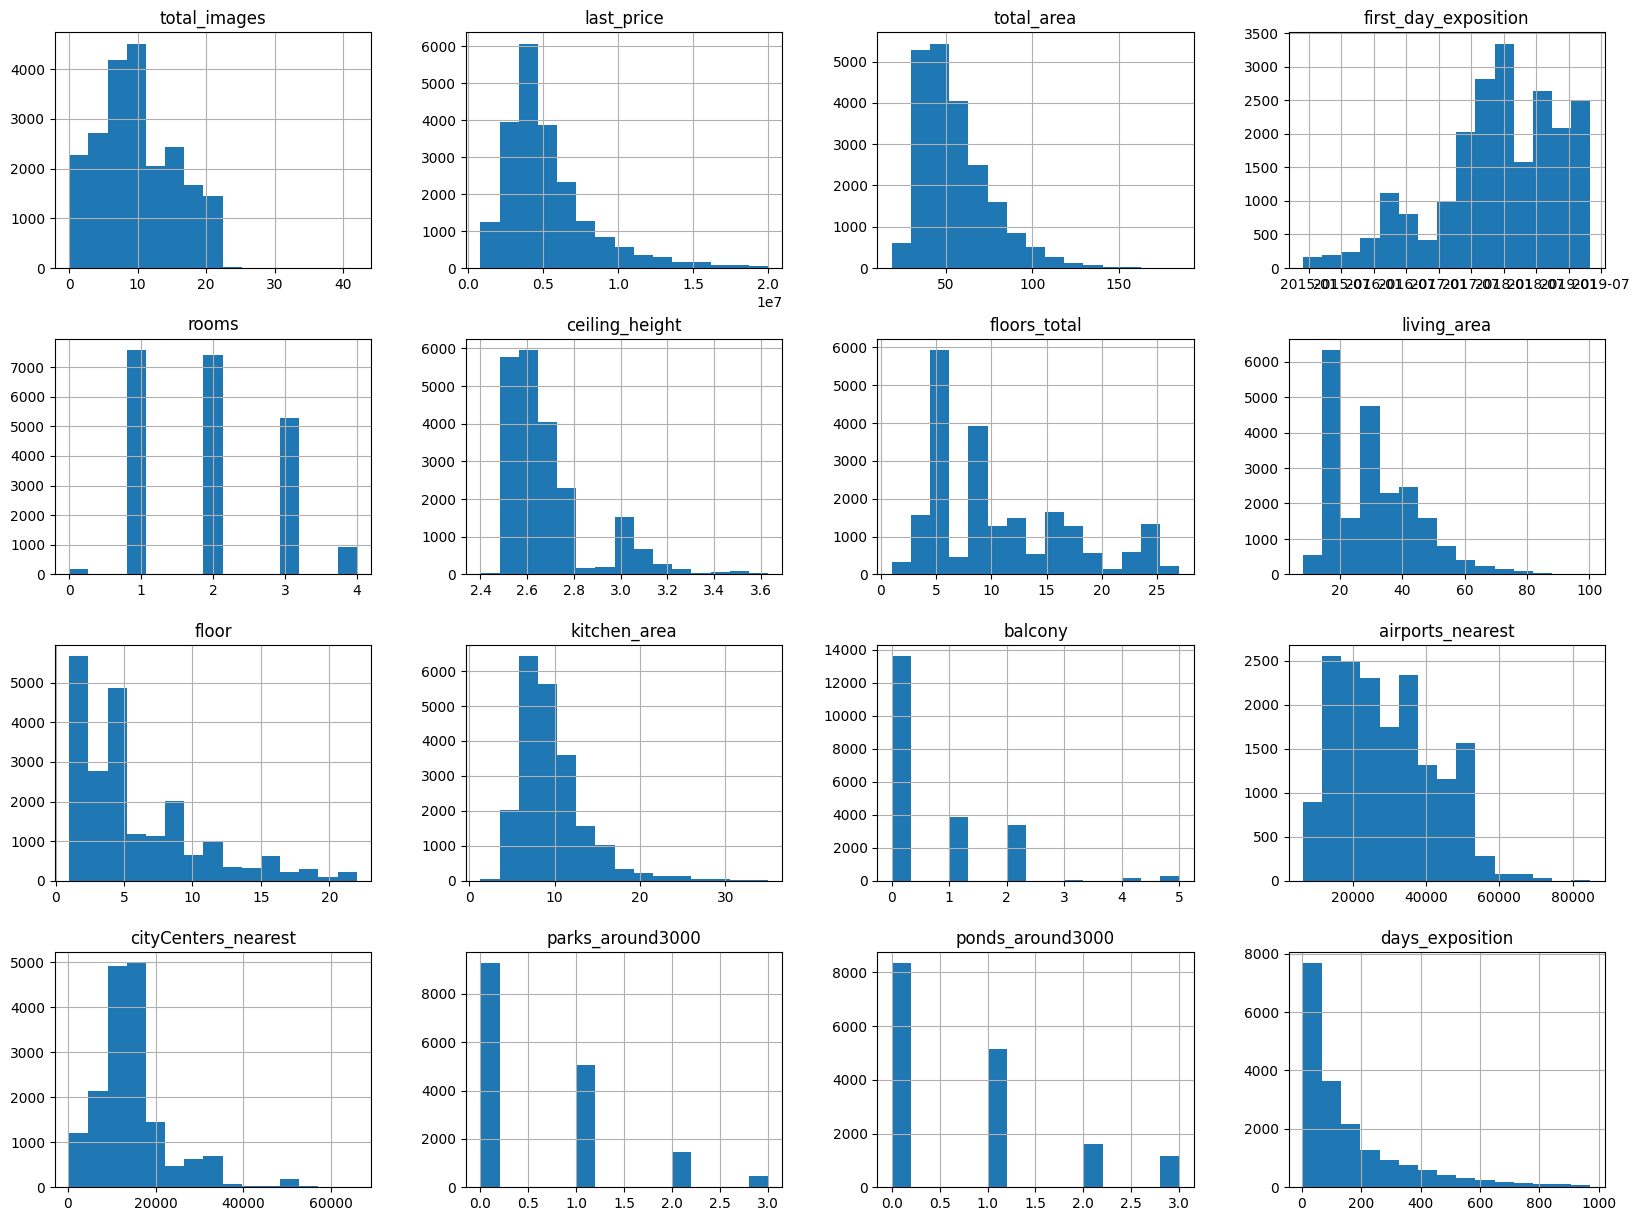

In [168]:
df_copy.hist(bins=15, figsize=(20,15));

In [169]:
df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']].apply (['count', 'min', 'max', 'median'])

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,23585.0,23585.0,23486.00,20415.0,23585.0,23585.0,23585.0,23585.0,23585.0
min,0.0,12.0,1.75,1.0,12190.0,7.0,1.3,1.0,1.0
max,19.0,900.0,14.00,1580.0,763000000.0,409.7,112.0,33.0,60.0
median,2.0,52.0,2.60,95.0,4650000.0,30.0,9.0,4.0,9.0


In [170]:
df_copy[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']].apply (['count', 'min', 'max', 'median'])

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,21335.0,21335.0,21335.00,18577.0,21335.0,21335.0,21335.0,21335.0,21335.0
min,0.0,18.8,2.40,4.0,820000.0,8.0,1.3,1.0,1.0
max,4.0,185.0,3.63,972.0,19999000.0,100.4,35.0,22.0,27.0
median,2.0,50.3,2.60,92.0,4500000.0,29.5,9.0,4.0,9.0


In [171]:
df.describe() - df_copy.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition
count,2250.000000,2.250000e+03,2250.000000,2250.000000,2151.000000,2250.000000,2250.000000,2250.000000,2250.000000,2250.000000,1895.000000,1895.000000,1828.000000,1828.000000,1838.000000
mean,0.053918,1.266716e+06,5.335257,0.111043,0.028417,-0.039541,2.999864,0.118826,0.737524,-0.008286,-147.659913,-484.951153,0.035805,0.042756,16.567350
std,0.086368,7.947969e+06,14.740292,0.181416,0.080824,0.169049,8.002270,0.319862,1.967147,0.001970,-203.981186,103.182710,0.030506,0.032860,37.070004
min,0.000000,-8.078100e+05,-6.800000,0.000000,-0.650000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-106.000000,0.000000,0.000000,-3.000000
25%,0.000000,1.300000e+04,0.300000,0.000000,0.010000,0.000000,0.340000,0.000000,0.000000,0.000000,322.000000,-923.750000,0.000000,0.000000,1.000000
50%,0.000000,1.500000e+05,1.700000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,-573.500000,-322.000000,0.000000,1.000000,3.000000
75%,0.000000,5.000000e+05,4.100000,0.000000,0.000000,0.000000,2.000000,0.000000,0.800000,0.000000,-478.750000,-136.250000,0.000000,0.000000,15.000000
max,8.000000,7.430010e+08,715.000000,15.000000,10.370000,33.000000,309.300000,11.000000,77.000000,0.000000,16.000000,16.000000,0.000000,0.000000,608.000000


Таким образом, при избавлении от выбросов мы потерли порядка 7% данных, но медиану параметров оставили на прежнем уровне и понизили стандартное отклонение

In [172]:
df = df_copy

In [173]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [174]:
# check
df_check.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


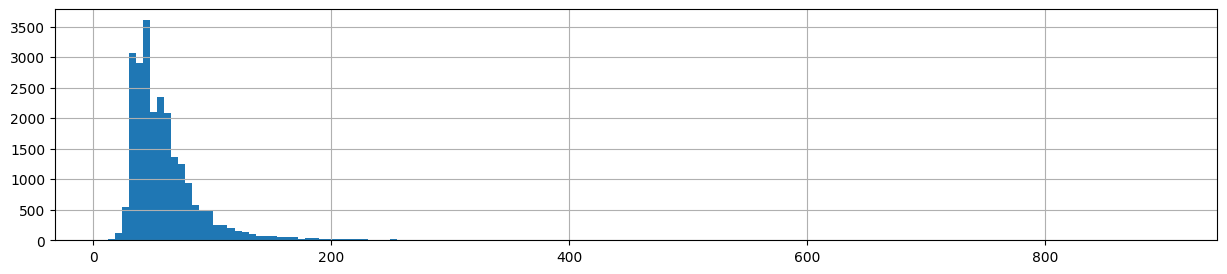

In [175]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

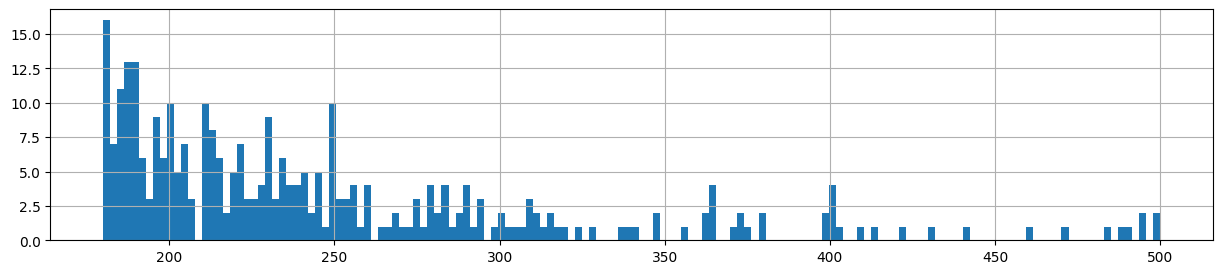

In [176]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

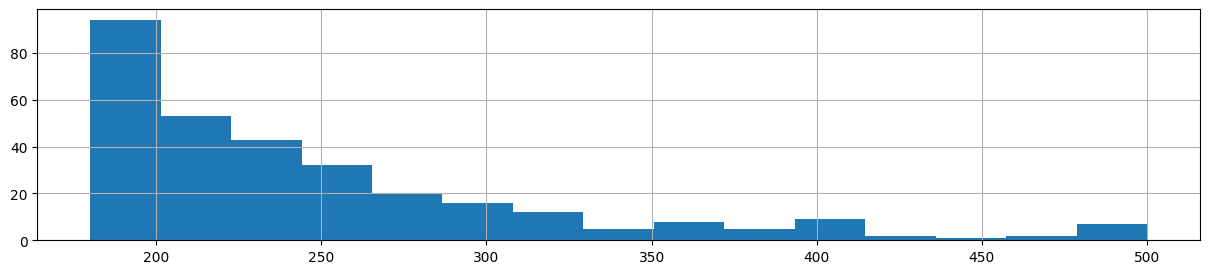

In [177]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

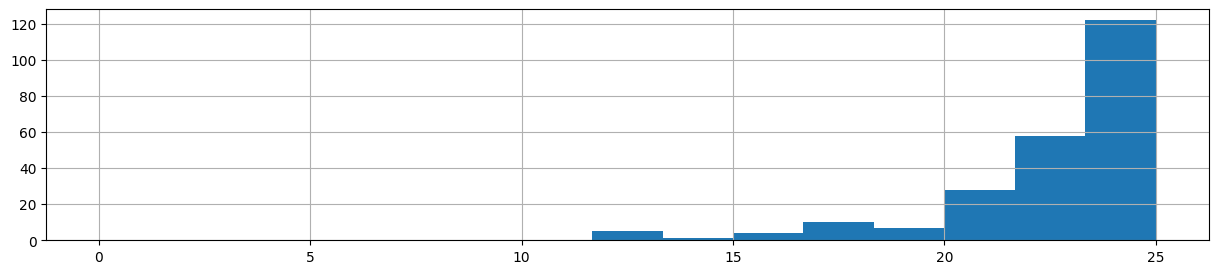

In [178]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [179]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.001200,0.00,20.00,2.40,3.00,"562,116.00",9.00,3.00,1.00,2.00
0.010000,1.00,25.26,2.50,4.00,"1,000,000.00",12.49,4.08,1.00,2.00
0.500000,2.00,52.00,2.60,95.00,"4,650,000.00",30.00,9.00,4.00,9.00
0.990000,5.00,197.30,3.60,"1,068.88","36,000,000.00",117.31,35.36,23.00,26.00
0.998800,8.00,380.00,4.40,"1,369.96","124,779,936.00",219.15,62.29,26.00,35.00


### Посчитайте и добавьте в таблицу новые столбцы

Добавим в таблицу новые столбцы:
- цену одного квадратного метра
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
- месяц публикации объявления
- год публикации объявления
- тип этажа квартиры (значения — «‎первый», «последний», «другой»)
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений)

In [180]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'studio', 'open_plan', 'kitchen_area', 'balcony', 'locality_name',
       'airports_nearest', 'cityCenters_nearest', 'parks_around3000',
       'ponds_around3000', 'days_exposition', 'cityCenters_nearest_cat'],
      dtype='object')

In [181]:
df['meter_price'] = df['last_price'] / df['total_area']

In [182]:
df['day_of_week_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year

In [183]:
df['floor_type'] = 'другой'
df.loc[(df['floor'] == df['floors_total']), 'floor_type'] = 'последний'
df.loc[(df['floor'] == 1), 'floor_type'] = 'первый'

In [184]:
df['cityCenters_nearest_km'] = round(df['cityCenters_nearest'] / 1000)

In [185]:
df['last_price_million'] = df['last_price'] / 1000000

Проверим картографические пропуски по годам

In [186]:
try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [187]:
df_check['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])
df_check['year_exposition'] = df_check['first_day_exposition'].dt.year

In [188]:
df_check[df_check['cityCenters_nearest'].isna()]['year_exposition'].value_counts()

2018.0    2082
2017.0    1656
2019.0     617
2016.0     535
2015.0     177
2014.0      12
Name: year_exposition, dtype: int64

In [189]:
df_check['year_exposition'].value_counts()

2018.0    7824
2017.0    7481
2019.0    2621
2016.0    2479
2015.0     858
2014.0      72
Name: year_exposition, dtype: int64

In [190]:
(df_check[df_check['cityCenters_nearest'].isna()]['year_exposition'].value_counts() /
df_check['year_exposition'].value_counts())

2018.0    0.266104
2017.0    0.221361
2019.0    0.235406
2016.0    0.215813
2015.0    0.206294
2014.0    0.166667
Name: year_exposition, dtype: float64

Больше всего картографических пропусков было в 2018 году, общая тенденция - количество пропусков растет с течением времени, но здесь стоит учитывать и рост объявлений. Некорректно будет сравнивать 2014-2015 года с 2018 ввиду большой разницы в количестве

Создадим категории цен, общей площади, расстояния до центра города и количества дней размещения объявления.

In [191]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'studio', 'open_plan', 'kitchen_area', 'balcony', 'locality_name',
       'airports_nearest', 'cityCenters_nearest', 'parks_around3000',
       'ponds_around3000', 'days_exposition', 'cityCenters_nearest_cat',
       'meter_price', 'day_of_week_exposition', 'month_exposition',
       'year_exposition', 'floor_type', 'cityCenters_nearest_km',
       'last_price_million'],
      dtype='object')

In [192]:
df['last_price_million_cat'] = pd.qcut(df['last_price_million'], q=5)
df['last_price_million_cat'].value_counts()

(4.0, 5.1]       4437
(0.819, 3.15]    4330
(6.9, 19.999]    4264
(3.15, 4.0]      4219
(5.1, 6.9]       4085
Name: last_price_million_cat, dtype: int64

In [193]:
df['total_area_cat'] = pd.qcut(df['total_area'], q=3)
df['total_area_cat'].value_counts()

(18.799, 43.0]    7272
(43.0, 60.0]      7088
(60.0, 185.0]     6975
Name: total_area_cat, dtype: int64

In [194]:
df['days_exposition_cat'] = pd.cut(df['days_exposition'], bins=[0, 46, 121, 300, 2000])
df['days_exposition_cat'].value_counts()

(0, 46]        5473
(46, 121]      5374
(121, 300]     4482
(300, 2000]    3248
Name: days_exposition_cat, dtype: int64

### Проведите исследовательский анализ данных

#### Распределения количественных переменных

Посмотрим на динамику количества объявлений за период

<Axes: xlabel='year_exposition,month_exposition'>

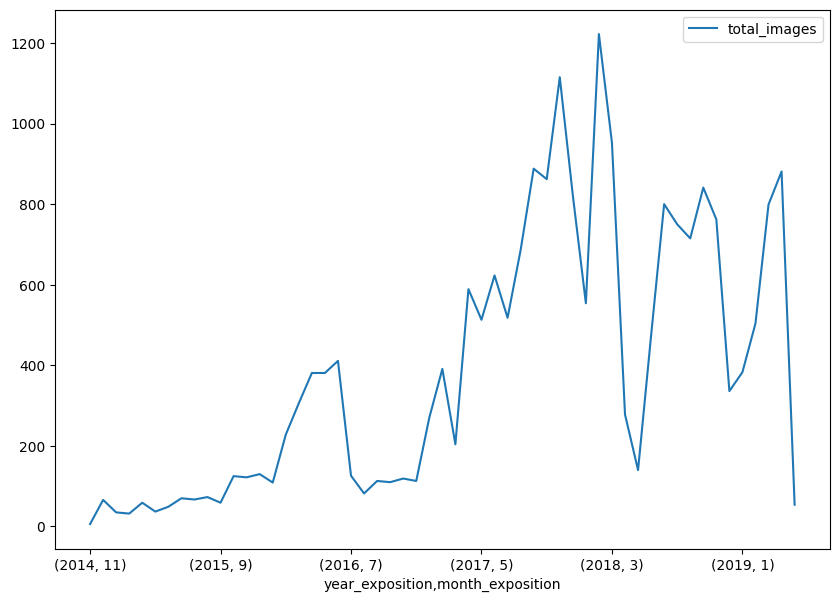

In [195]:
df.groupby(['year_exposition', 'month_exposition'])[['total_images']].count().plot(figsize=(10,7))

Посмотрим на распределения количественных переменных

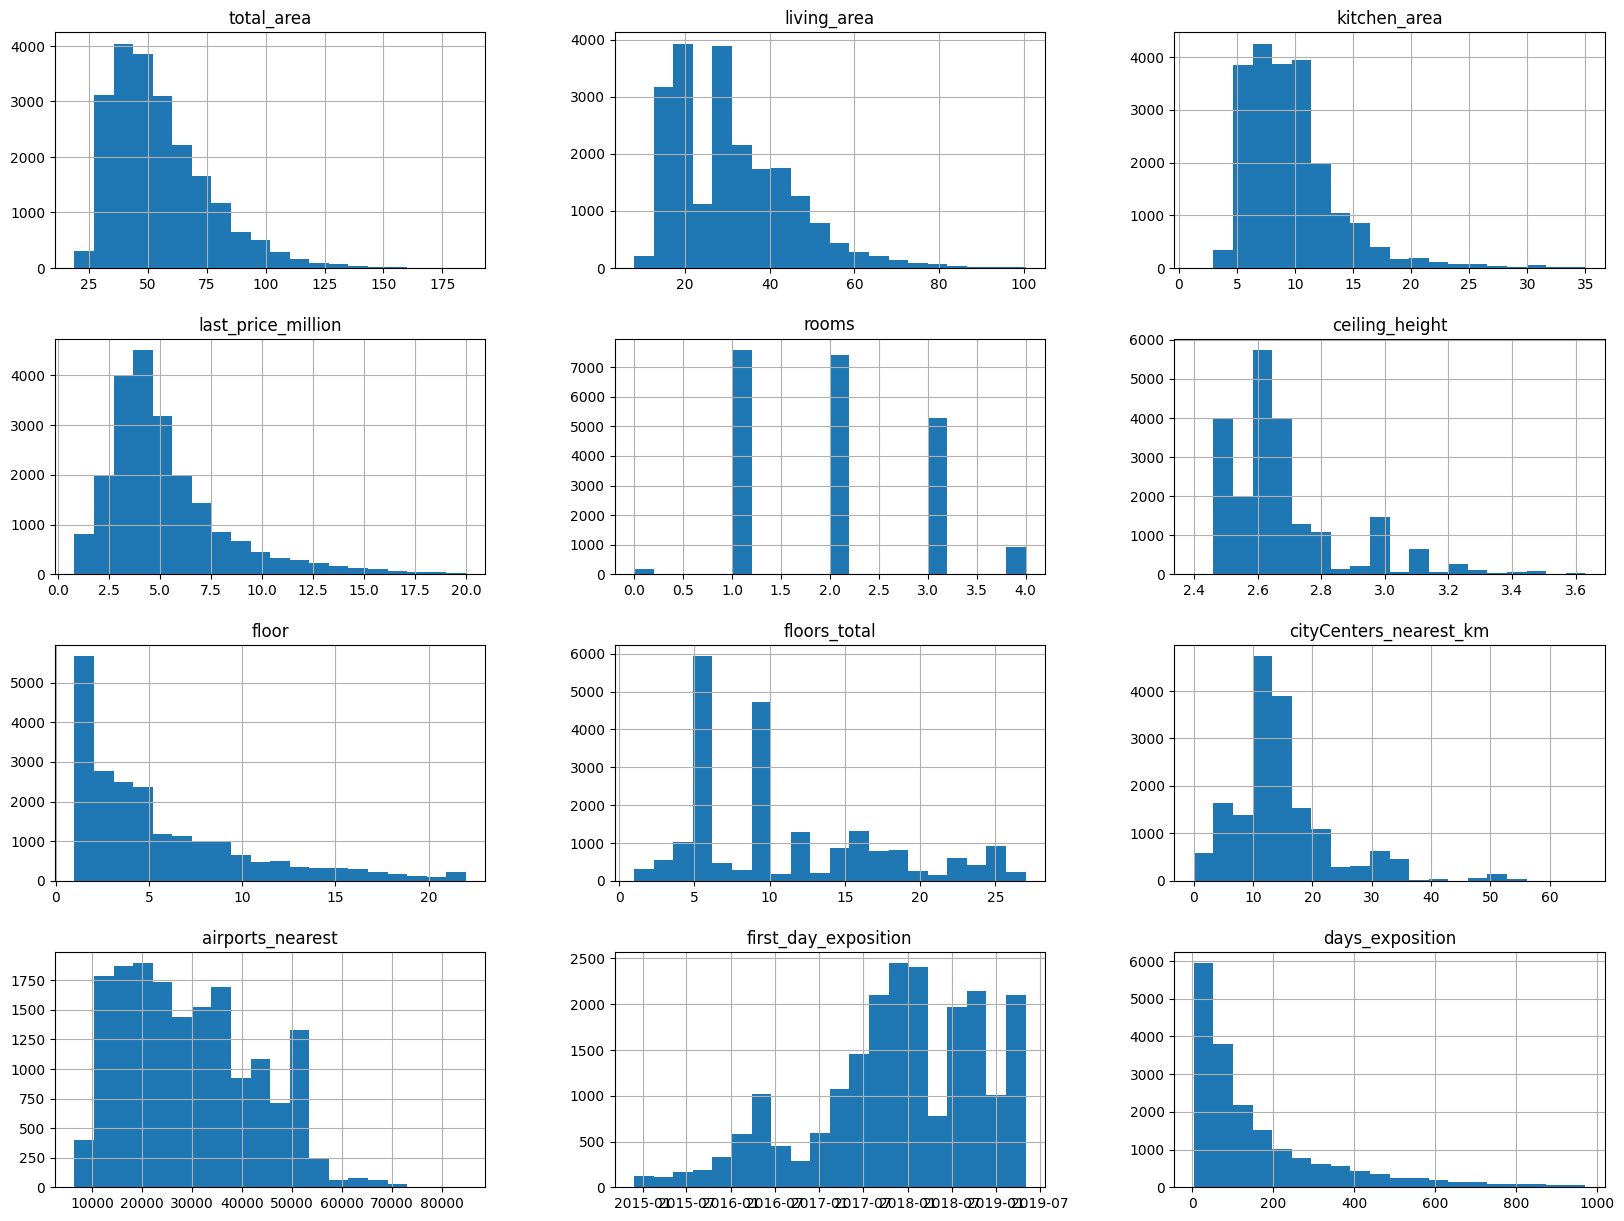

In [196]:
(
    df[['total_area', 'living_area', 'kitchen_area', 'last_price_million',
        'rooms', 'ceiling_height', 'floor', 'floor_type', 'floors_total',
        'cityCenters_nearest_km', 'airports_nearest', 'first_day_exposition',
        'days_exposition']].hist(bins=20, figsize=(20,15))
)
plt.show()

Изучите следующие параметры объектов:
общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
этаж квартиры;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего аэропорта;
расстояние до ближайшего парка;
день и месяц публикации объявления.

0
4
4.0
2.0


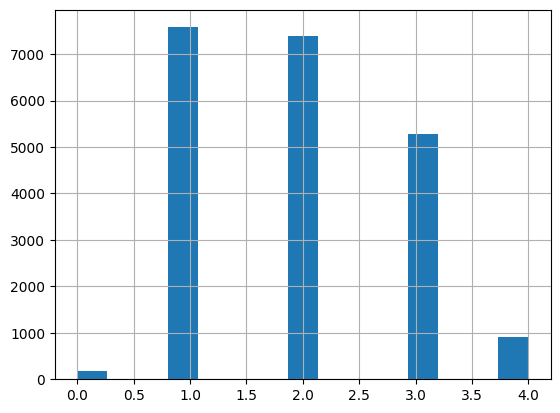

In [197]:
df['rooms'].hist(bins=15)
print(df['rooms'].min())
print(df['rooms'].max())
print(df['rooms'].quantile(0.98))
print(df['rooms'].median())

1
22
19.0
4.0


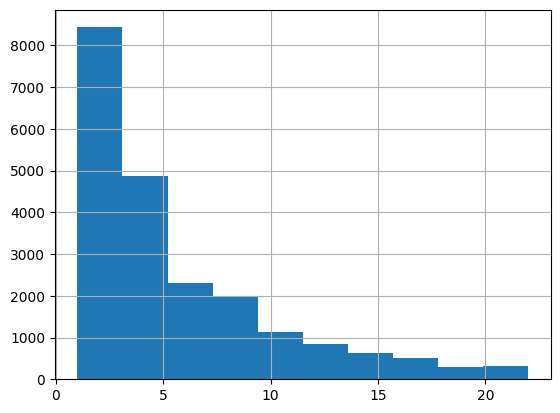

In [198]:
df['floor'].hist()
print(df['floor'].min())
print(df['floor'].max())
print(df['floor'].quantile(0.98))
print(df['floor'].median())

<Axes: >

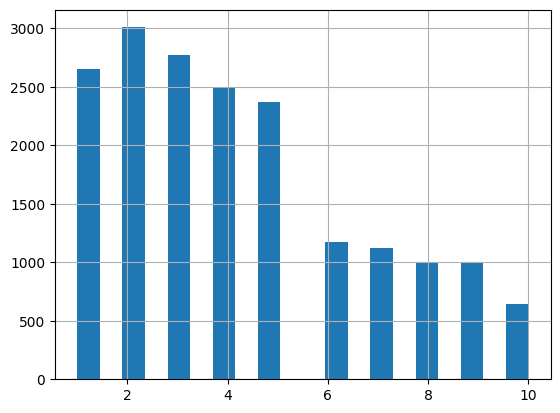

In [199]:
df['floor'].hist(range=(1,10), bins=20)

Больше всего квартир с 1 по 5 этаж, это связано с общим количеством этажей - дома до 5 этажей встречаются чаще. Проверим

1
27
25.0
9.0


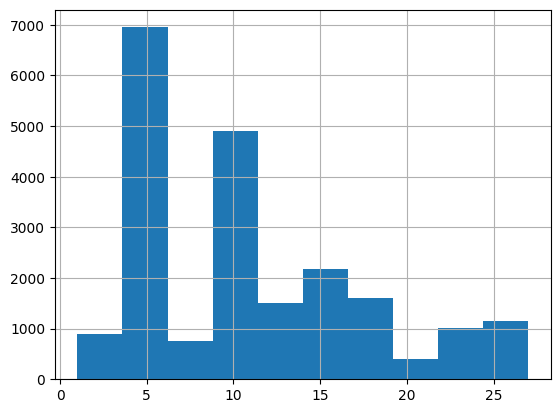

In [200]:
df['floors_total'].hist()
print(df['floors_total'].min())
print(df['floors_total'].max())
print(df['floors_total'].quantile(0.98))
print(df['floors_total'].median())

<Axes: >

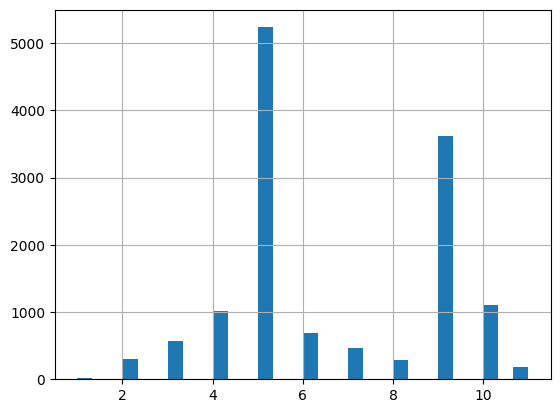

In [201]:
df['floors_total'].hist(range=(1,11), bins=30)

Да, больше всего пятиэтажек, далее по популярности 9-этажки

<Axes: >

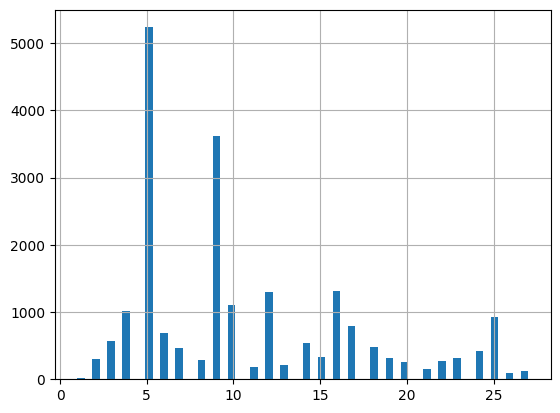

In [202]:
# check
df['floors_total'].hist( bins=60)

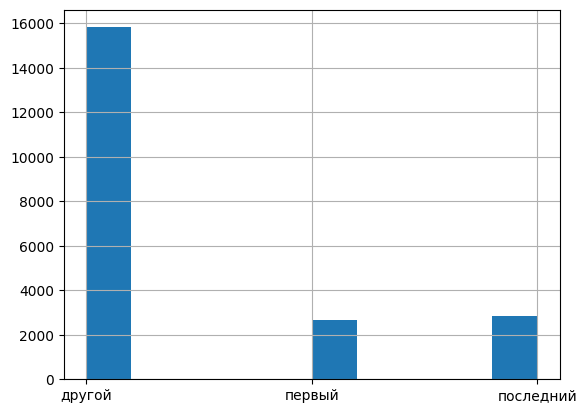

In [203]:
df['floor_type'].hist();

2.4000000000000004
3.63
3.1
2.6


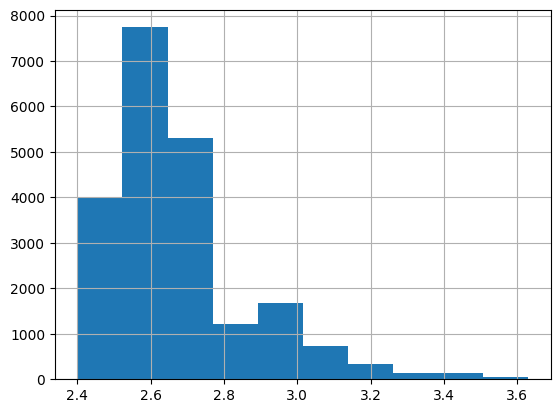

In [204]:
df['ceiling_height'].hist()
print(df['ceiling_height'].min())
print(df['ceiling_height'].max())
print(df['ceiling_height'].quantile(0.95))
print(df['ceiling_height'].median())

0.0
66.0
32.0
14.0


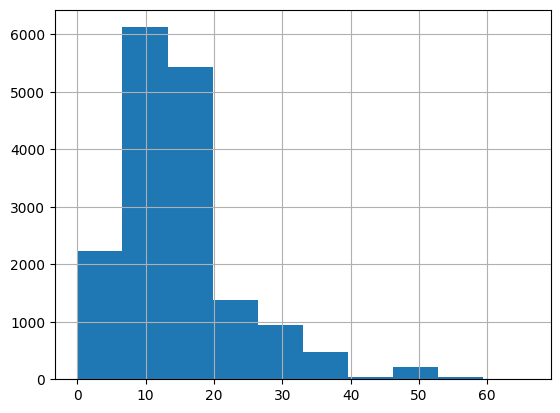

In [205]:
df['cityCenters_nearest_km'].hist()
print(df['cityCenters_nearest_km'].min())
print(df['cityCenters_nearest_km'].max())
print(df['cityCenters_nearest_km'].quantile(0.95))
print(df['cityCenters_nearest_km'].median())

<Axes: >

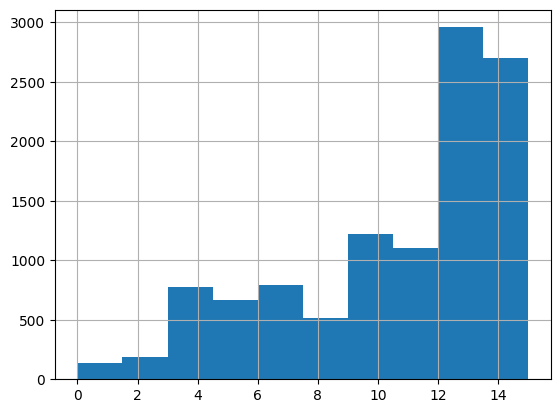

In [206]:
df['cityCenters_nearest_km'].hist(range=(0,15))

18.8
185.0
110.0
50.3


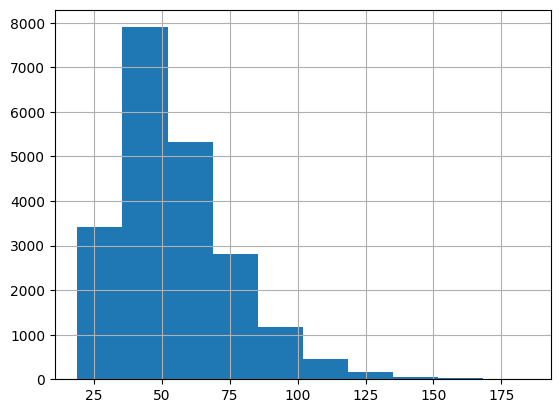

In [207]:
df['total_area'].hist()
print(df['total_area'].min())
print(df['total_area'].max())
print(df['total_area'].quantile(0.98))
print(df['total_area'].median())

8.0
100.4
67.0
29.5


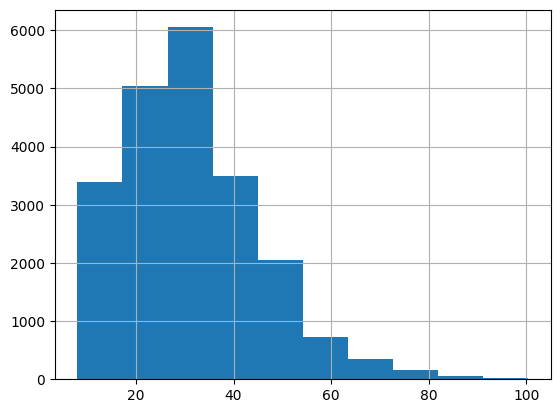

In [208]:
df['living_area'].hist()
print(df['living_area'].min())
print(df['living_area'].max())
print(df['living_area'].quantile(0.98))
print(df['living_area'].median())

1.3
35.0
21.5
9.0


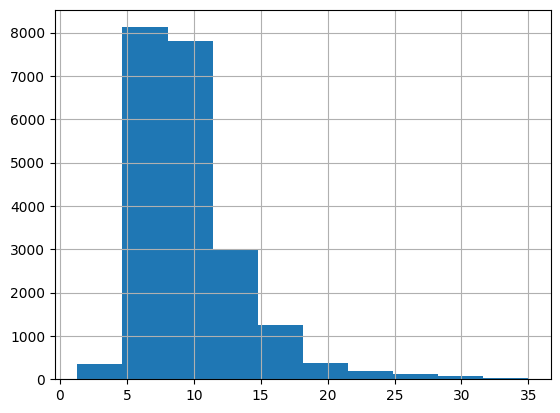

In [209]:
df['kitchen_area'].hist()
print(df['kitchen_area'].min())
print(df['kitchen_area'].max())
print(df['kitchen_area'].quantile(0.98))
print(df['kitchen_area'].median())

820000.0
19999000.0
14400000.0
4500000.0


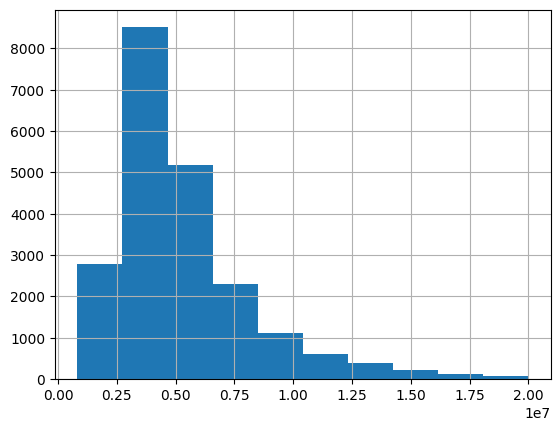

In [210]:
df['last_price'].hist()
print(df['last_price'].min())
print(df['last_price'].max())
print(df['last_price'].quantile(0.98))
print(df['last_price'].median())

<Axes: xlabel='last_price_million', ylabel='Count'>

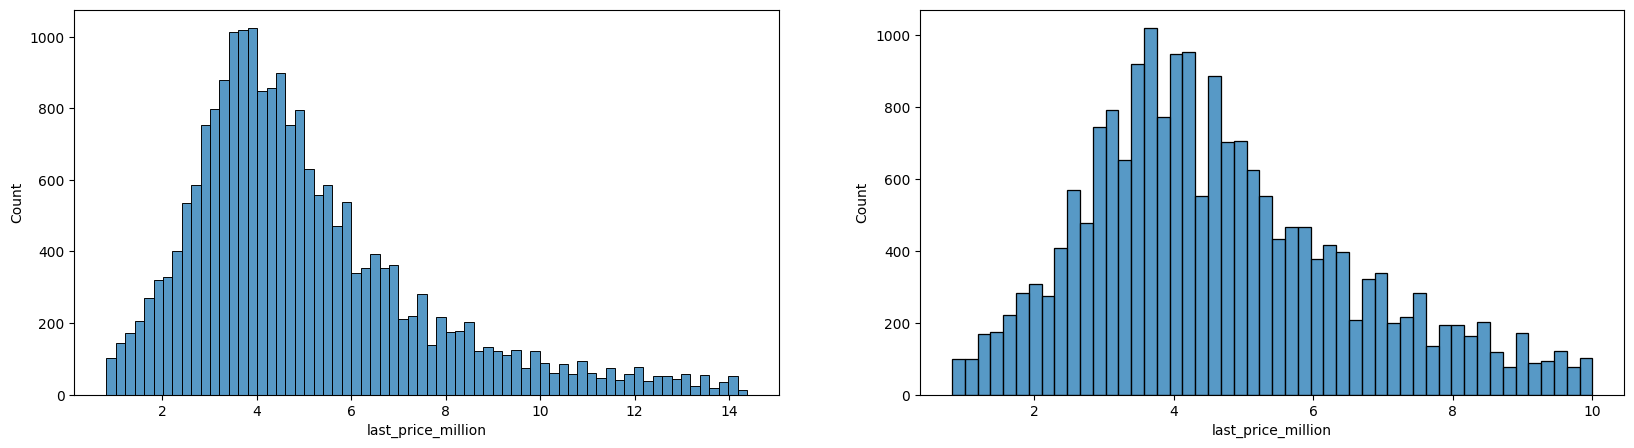

In [211]:
plt.figure(figsize=(20,5))

pylab.subplot(1, 2, 1)
sns.histplot(data=df[df['last_price_million'] < df['last_price_million'].quantile(0.98)]['last_price_million'])

pylab.subplot(1, 2, 2)
sns.histplot(data=df[df['last_price_million'] < 10]['last_price_million'])

6450.0
84853.0
54686.85999999972
27752.5


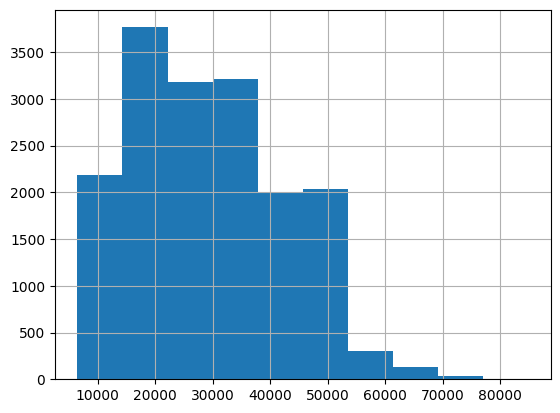

In [212]:
df['airports_nearest'].hist()
print(df['airports_nearest'].min())
print(df['airports_nearest'].max())
print(df['airports_nearest'].quantile(0.98))
print(df['airports_nearest'].median())

0.0
3.0
3.0
0.0


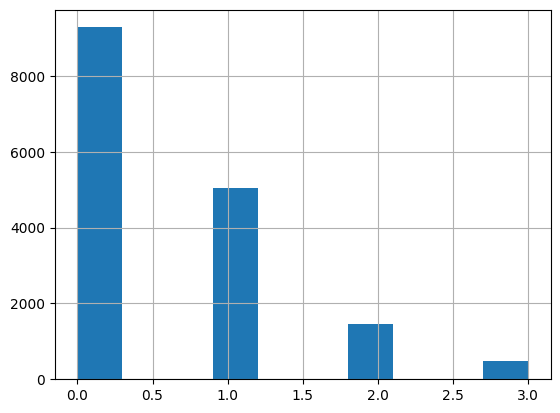

In [213]:
df['parks_around3000'].hist()
print(df['parks_around3000'].min())
print(df['parks_around3000'].max())
print(df['parks_around3000'].quantile(0.98))
print(df['parks_around3000'].median())

In [214]:
df['parks_around3000'].value_counts()

0.0    9284
1.0    5055
2.0    1449
3.0     469
Name: parks_around3000, dtype: int64

0
6
6.0
3.0


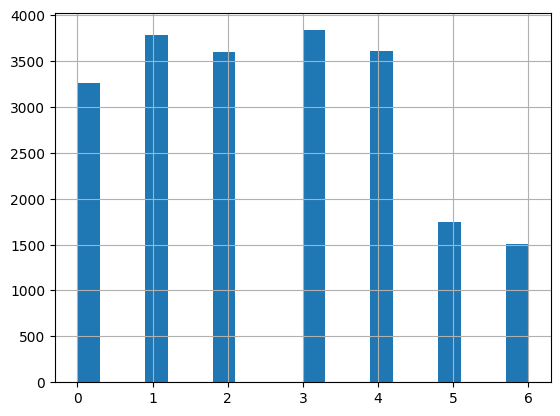

In [215]:
df['day_of_week_exposition'].hist(bins=20)
print(df['day_of_week_exposition'].min())
print(df['day_of_week_exposition'].max())
print(df['day_of_week_exposition'].quantile(0.98))
print(df['day_of_week_exposition'].median())

1
12
12.0
6.0


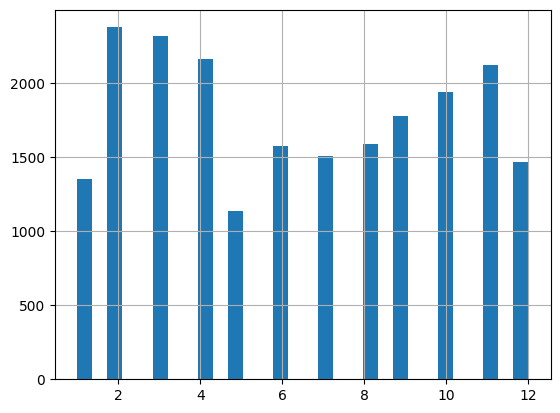

In [216]:
df['month_exposition'].hist(bins=30)
print(df['month_exposition'].min())
print(df['month_exposition'].max())
print(df['month_exposition'].quantile(0.98))
print(df['month_exposition'].median())

Сделаем несколько выводов после анализа гистограмм:

- медиана площади - 50 кв метров, медиана жилой площади - 30 метров, медиана площади кухни - 9 метров

- больше всего квартир с 1 по 5 этаж, это связано с общим количеством этажей

- у большинства квартир отсутствуют парки в пределах 3 км

- преимущественно объявление выкладываются в будни

- в целом за все время всего объявлений выкладывается в мае, январе и декабре, больше всего в феврале после чего наблюдается спад до минимального в мае и с летних месяцев снова начинает рост до ноября включительно

#### Проверим скорость продажи квартир

In [217]:
df['days_exposition'].describe()

count    18577.000000
mean       164.347957
std        182.672167
min          4.000000
25%         44.000000
50%         92.000000
75%        217.000000
max        972.000000
Name: days_exposition, dtype: float64

44.00000000000001
217.0


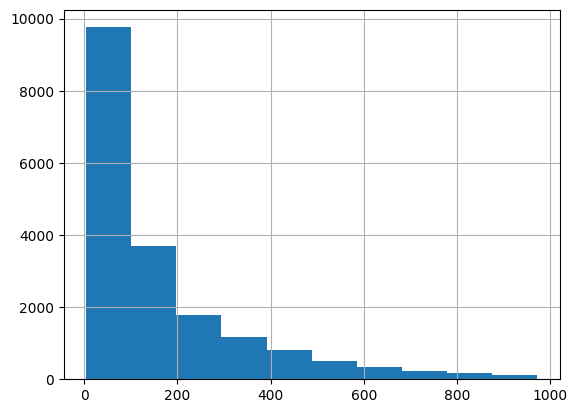

In [218]:
df['days_exposition'].hist()
print(df['days_exposition'].quantile(0.25))
print(df['days_exposition'].quantile(0.75))

<Axes: >

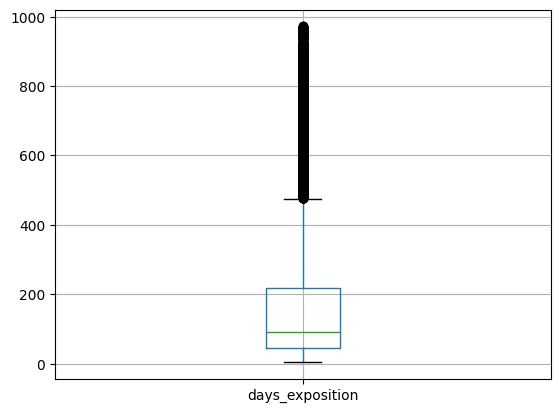

In [219]:
df[['days_exposition']].boxplot()

In [220]:
print('Количество квартир с продажами свыше 217 дней:', (df[df['days_exposition'] > df['days_exposition'].quantile(0.75)]
                                                         ['last_price_million'].count()))
print('Средняя цена таких квартир:', df[df['days_exposition'] > df['days_exposition'].quantile(0.75)]['last_price_million'].mean())
print('Медианная цена таких квартир:', df[df['days_exposition'] > df['days_exposition'].quantile(0.75)]['last_price_million'].median())

Количество квартир с продажами свыше 217 дней: 4624
Средняя цена таких квартир: 5.490824090181662
Медианная цена таких квартир: 4.6


- 75% квартир продаются за срок до 8 месяцев

Посмотрим на квартиры, которые продаются долго

In [221]:
(
    df[df['days_exposition'] > df['days_exposition'].quantile(0.75)].
    pivot_table(index='cityCenters_nearest_cat', columns='last_price_million_cat',
                values='airports_nearest', aggfunc='count')
)

last_price_million_cat,"(0.819, 3.15]","(3.15, 4.0]","(4.0, 5.1]","(5.1, 6.9]","(6.9, 19.999]"
cityCenters_nearest_cat,,,,,
"(180.999, 4823.0]",0,5,25,90,279
"(4823.0, 8080.0]",0,15,31,110,231
"(8080.0, 10713.2]",18,63,76,88,114
"(10713.2, 12063.4]",19,88,90,96,74
"(12063.4, 13266.0]",5,71,89,84,72
"(13266.0, 14673.0]",16,67,99,86,81
"(14673.0, 15949.1]",21,85,99,75,58
"(15949.1, 18194.0]",27,88,105,75,48
"(18194.0, 25796.0]",67,92,83,70,24


In [222]:
(
    df[df['days_exposition'] > df['days_exposition'].quantile(0.75)].
    pivot_table(index='cityCenters_nearest_cat', columns='last_price_million_cat',
                values='airports_nearest', aggfunc='count')
/
    df.
    pivot_table(index='cityCenters_nearest_cat', columns='last_price_million_cat',
                values='airports_nearest', aggfunc='count')
* 100)

last_price_million_cat,"(0.819, 3.15]","(3.15, 4.0]","(4.0, 5.1]","(5.1, 6.9]","(6.9, 19.999]"
cityCenters_nearest_cat,,,,,
"(180.999, 4823.0]",0.000000,18.518519,27.777778,31.141869,31.313131
"(4823.0, 8080.0]",0.000000,18.987342,19.254658,28.645833,28.448276
"(8080.0, 10713.2]",17.475728,20.257235,18.673219,22.976501,22.093023
"(10713.2, 12063.4]",23.456790,22.739018,17.821782,20.600858,21.700880
"(12063.4, 13266.0]",7.936508,20.639535,18.503119,17.463617,17.821782
"(13266.0, 14673.0]",19.512195,17.585302,18.644068,19.861432,22.191781
"(14673.0, 15949.1]",18.103448,21.628499,19.298246,17.321016,17.469880
"(15949.1, 18194.0]",17.532468,19.512195,20.038168,18.610422,20.779221
"(18194.0, 25796.0]",17.135550,17.898833,21.336761,23.648649,19.834711


<Axes: xlabel='last_price_million_cat', ylabel='cityCenters_nearest_cat'>

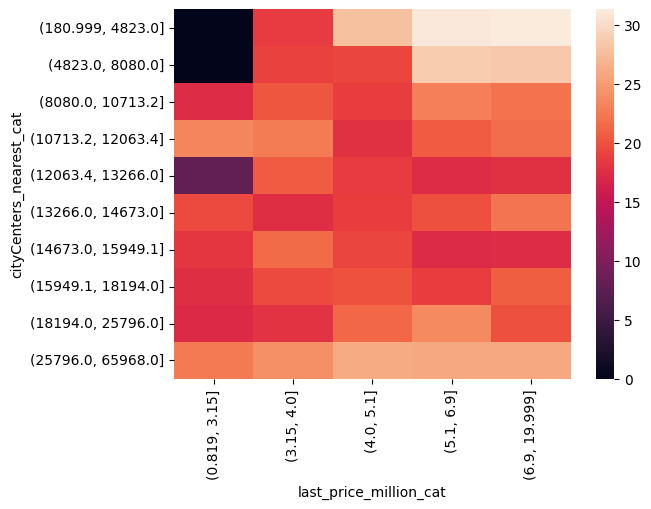

In [223]:
sns.heatmap(
(
    df[df['days_exposition'] > df['days_exposition'].quantile(0.75)].
    pivot_table(index='cityCenters_nearest_cat', columns='last_price_million_cat',
                values='airports_nearest', aggfunc='count')
/
    df.
    pivot_table(index='cityCenters_nearest_cat', columns='last_price_million_cat',
                values='airports_nearest', aggfunc='count')
* 100)
)

In [224]:
(
    df[df['days_exposition'] < df['days_exposition'].quantile(0.25)].
    pivot_table(index='cityCenters_nearest_cat', columns='last_price_million_cat',
                values='airports_nearest', aggfunc='count')
/
    df.
    pivot_table(index='cityCenters_nearest_cat', columns='last_price_million_cat',
                values='airports_nearest', aggfunc='count')
* 100)

last_price_million_cat,"(0.819, 3.15]","(3.15, 4.0]","(4.0, 5.1]","(5.1, 6.9]","(6.9, 19.999]"
cityCenters_nearest_cat,,,,,
"(180.999, 4823.0]",50.000000,33.333333,24.444444,20.415225,14.478114
"(4823.0, 8080.0]",37.500000,34.177215,26.086957,19.791667,15.270936
"(8080.0, 10713.2]",38.834951,27.974277,22.358722,21.671018,16.860465
"(10713.2, 12063.4]",35.802469,28.940568,22.772277,19.098712,16.715543
"(12063.4, 13266.0]",42.857143,29.651163,26.819127,23.908524,20.297030
"(13266.0, 14673.0]",29.268293,29.396325,28.060264,23.556582,20.547945
"(14673.0, 15949.1]",29.310345,26.208651,27.680312,24.018476,15.963855
"(15949.1, 18194.0]",31.168831,29.490022,23.854962,20.843672,18.181818
"(18194.0, 25796.0]",29.156010,24.708171,20.565553,19.594595,8.264463


<Axes: xlabel='last_price_million_cat', ylabel='cityCenters_nearest_cat'>

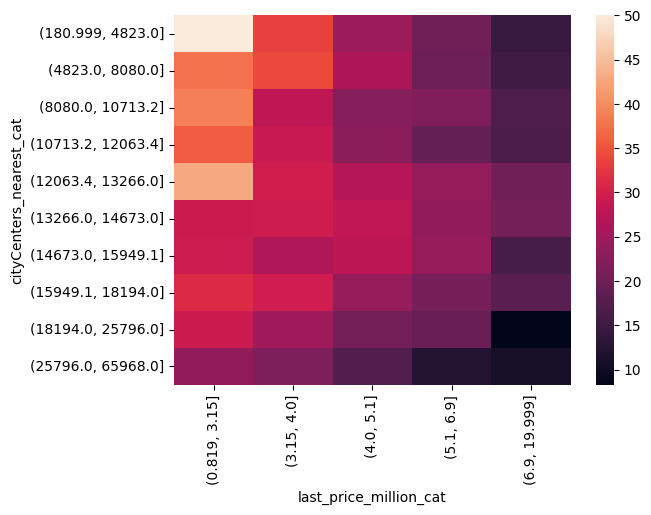

In [225]:
sns.heatmap(
(
    df[df['days_exposition'] < df['days_exposition'].quantile(0.25)].
    pivot_table(index='cityCenters_nearest_cat', columns='last_price_million_cat',
                values='airports_nearest', aggfunc='count')
/
    df.
    pivot_table(index='cityCenters_nearest_cat', columns='last_price_million_cat',
                values='airports_nearest', aggfunc='count')
* 100)
)

- можно сделать вывод, что долго продается историческая застройка (старый фонд) - в максимальной близости к центру и максимальными ценами.
- 50% квартир стоимостью до 3.15 млн и в близости до 4.8 км к центру продается в срок до 44 дней
- среди этой же категории продаж до 44 дней меньше всего продаж самый отдаленных от центра и дорогих квартир

In [226]:
(
    df[df['days_exposition'] > df['days_exposition'].
       quantile(0.75)].pivot_table(index='floor_type',
                                   columns='last_price_million_cat',
                                   values='airports_nearest',
                                   aggfunc='count')
)

last_price_million_cat,"(0.819, 3.15]","(3.15, 4.0]","(4.0, 5.1]","(5.1, 6.9]","(6.9, 19.999]"
floor_type,,,,,
другой,180,487,588,633,808
первый,55,122,106,119,70
последний,42,85,100,90,150


In [227]:
df.groupby('year_exposition').agg({'days_exposition': ['count', 'mean']})

days_exposition            
                          count        mean
year_exposition                            
2014                         61  702.803279
2015                        810  524.517284
2016                       2426  308.952185
2017                       7273  157.544892
2018                       7018   93.899687
2019                        989   31.377149

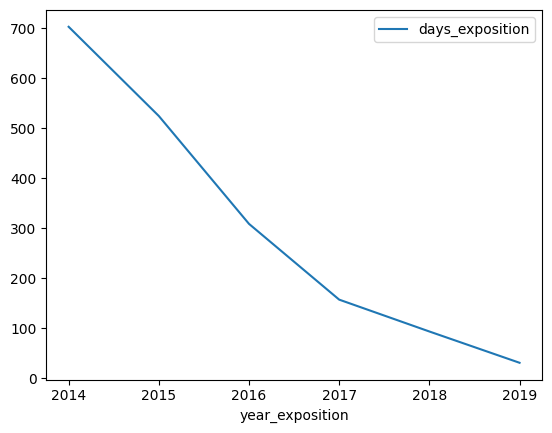

In [228]:
df.groupby('year_exposition')[['days_exposition']].mean().plot();

Мы наблюдаем явную тенденцию - со временем квартиры продаются быстрее (с 17 месяцев в 2015 году (23 месяца в 2014 году - данные только за декабрь) до 1 месяца в 2019 году). Среднее значение примерно равное 30 дням в 2019 году равно сроку платного объявления в регионе СПб и области. Посмотрим на моды в скорости продаж.

In [229]:
df['days_exposition'].mode()

0    45.0
Name: days_exposition, dtype: float64

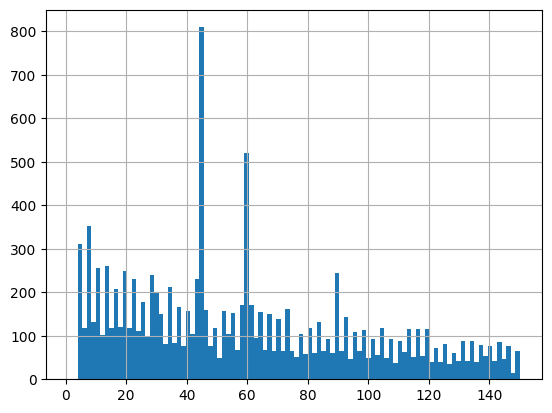

In [230]:
df['days_exposition'].hist(range=(1,150), bins=100);

In [231]:
df['days_exposition'].value_counts().head(7)

45.0    809
60.0    521
7.0     221
30.0    200
4.0     169
90.0    155
5.0     141
Name: days_exposition, dtype: int64

Среди наиболее часто встречаемых значений количества дней объявления стоит обратить внимание на 45, 60, 30 и 90 дней. Эти цифры коррелируют со сроками бесплатных объявлений в регионах, отличных от анализируемого. В нашем регионе срок бесплатного объявления до 120 дней, далее платные объявления продлеваются каждые 30 дней. Можно сделать предположение, что до 2019 года условия размещения были одни для всех регионов РФ. В таком случае, можно сделать вывод, что по завершению срока объявление снималось и не продлевалось. Таким образом, продажа квартиры не была совершена с большой долей вероятности.

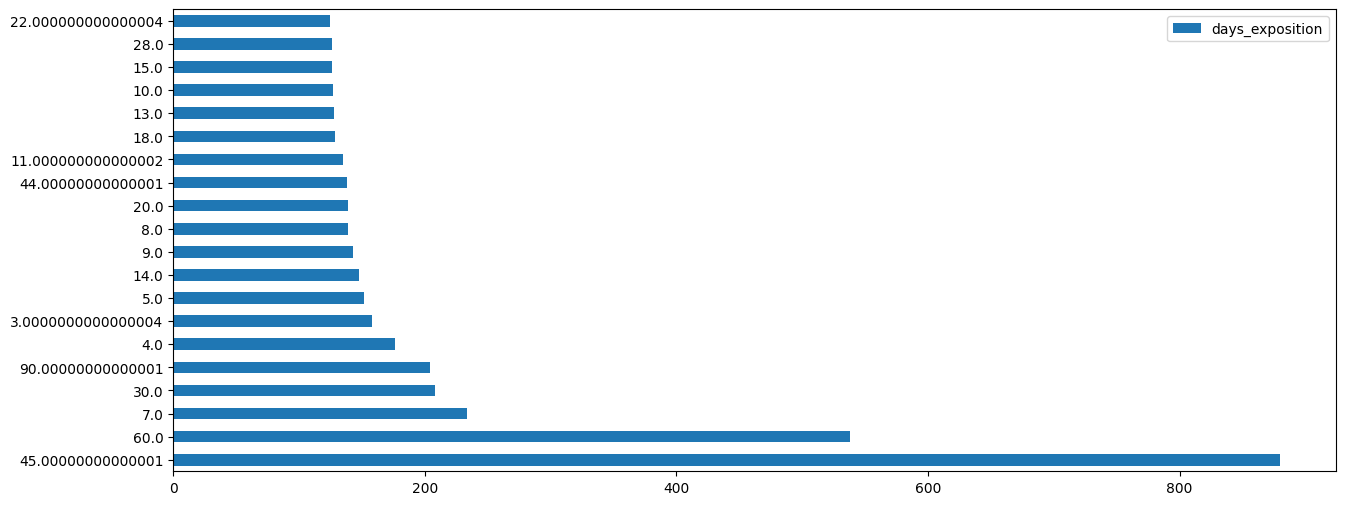

In [232]:
# check
# Моды на реальных данных


df_check['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

#### Факторы, больше всего влияющие на общую (полную) стоимость объекта

<Axes: xlabel='last_price_million_cat'>

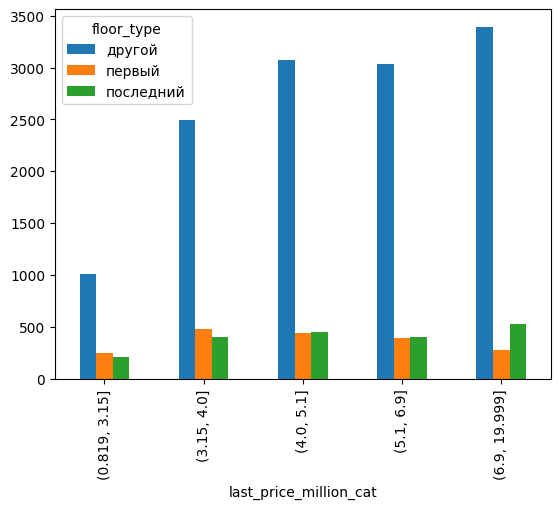

In [233]:
(df.pivot_table(index='last_price_million_cat', columns='floor_type', values='airports_nearest', aggfunc='count')).plot(kind='bar')

- В максимальном ценовом сегменте квартиры на последнем этаже преобладают над квартирами на первом
- В минимальном ценовом диапазоне квартиры на первом и последнем этажах встречаются чаще, чем в дргих диапазонах


<Axes: xlabel='year_exposition', ylabel='last_price'>

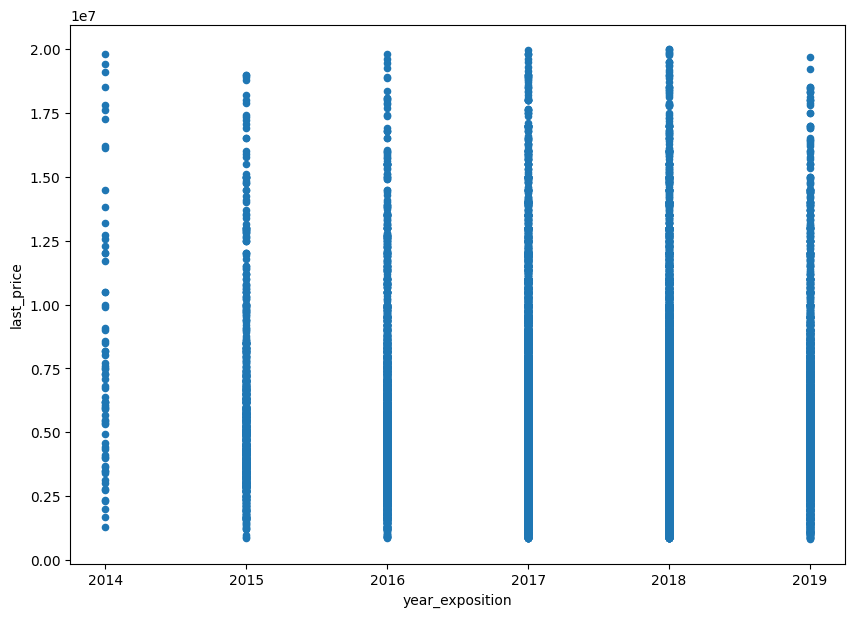

In [234]:
df.plot(kind='scatter', x='year_exposition', y='last_price', figsize=(10,7))

<Axes: xlabel='first_day_exposition', ylabel='last_price'>

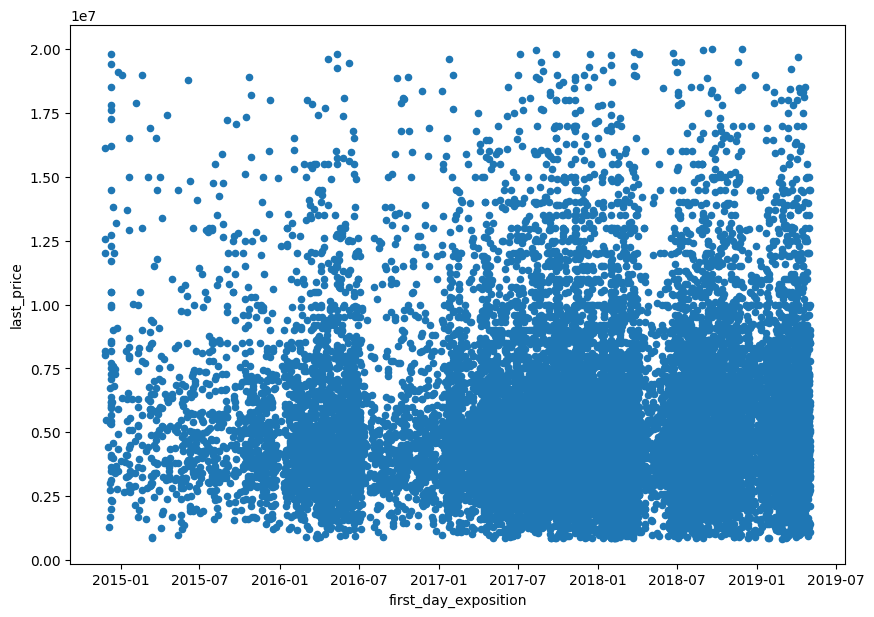

In [235]:
df.plot(kind='scatter', x='first_day_exposition', y='last_price', figsize=(10,7))

In [236]:
df.groupby('floor_type').agg({'last_price_million': ['count', 'mean']})

last_price_million          
                        count      mean
floor_type                             
другой                  15821  5.493834
первый                   2651  4.297068
последний                2863  4.965693

<Axes: xlabel='floor_type'>

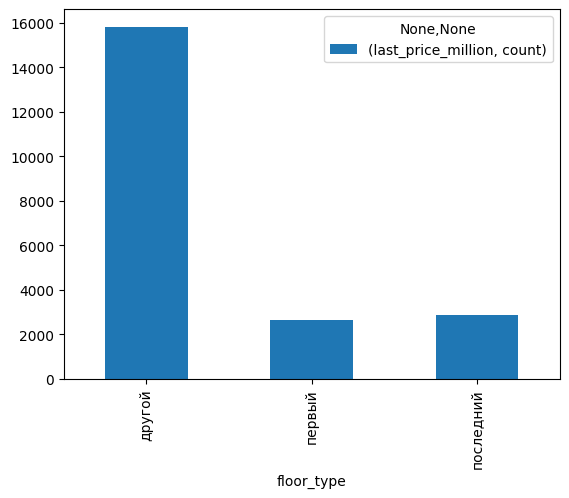

In [237]:
df.groupby('floor_type').agg({'last_price_million': ['count']}).plot(kind='bar')

<Axes: xlabel='floor_type'>

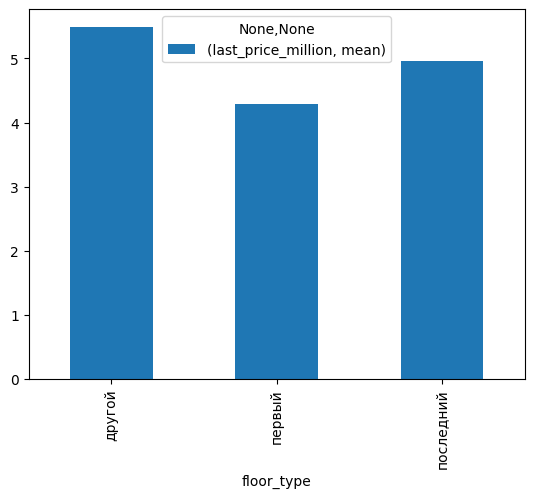

In [238]:
df.groupby('floor_type').agg({'last_price_million': ['mean']}).plot(kind='bar')

In [239]:
df.groupby('total_area_cat').agg({'last_price_million': ['count', 'mean']})

last_price_million          
                            count      mean
total_area_cat                             
(18.799, 43.0]               7272  3.462802
(43.0, 60.0]                 7088  4.593532
(60.0, 185.0]                6975  7.854597

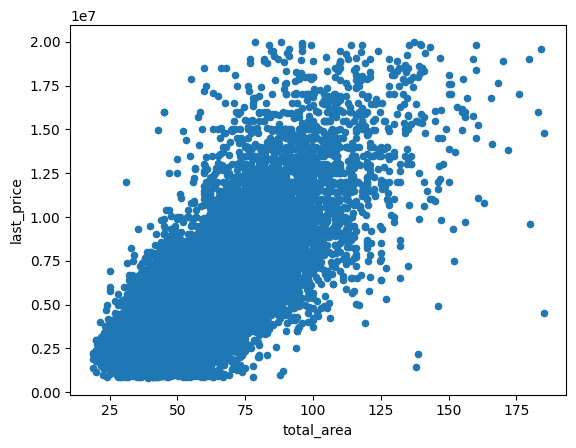

In [240]:
df.plot(x='total_area', y='last_price', kind='scatter');

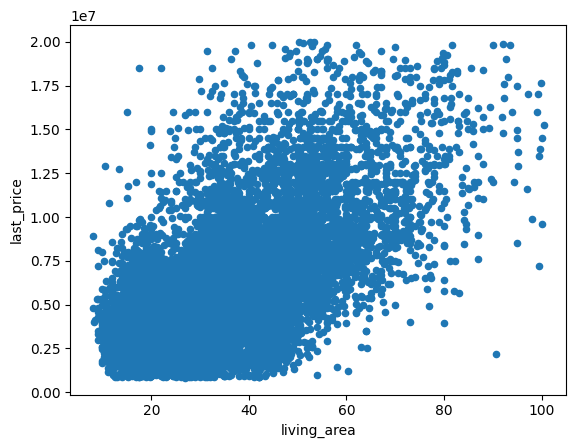

In [241]:
df.plot(x='living_area', y='last_price', kind='scatter');

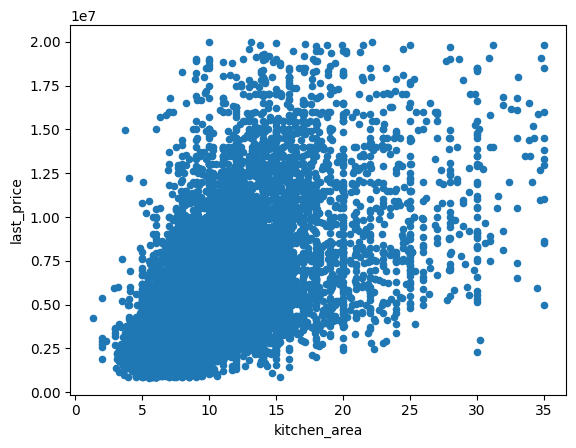

In [242]:
df.plot(x='kitchen_area', y='last_price', kind='scatter');

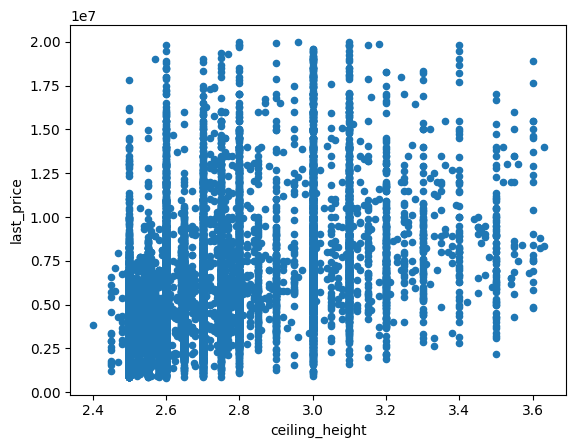

In [243]:
df.plot(x='ceiling_height', y='last_price', kind='scatter');

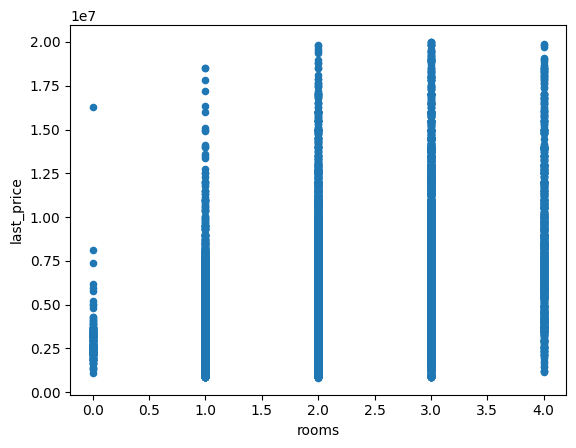

In [244]:
df.plot(x='rooms', y='last_price', kind='scatter');

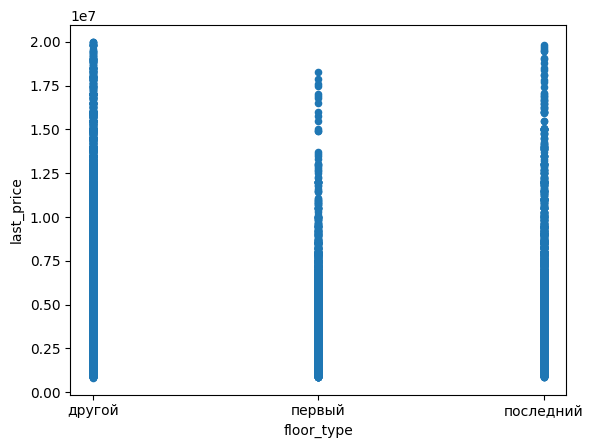

In [245]:
df.plot(x='floor_type', y='last_price', kind='scatter');

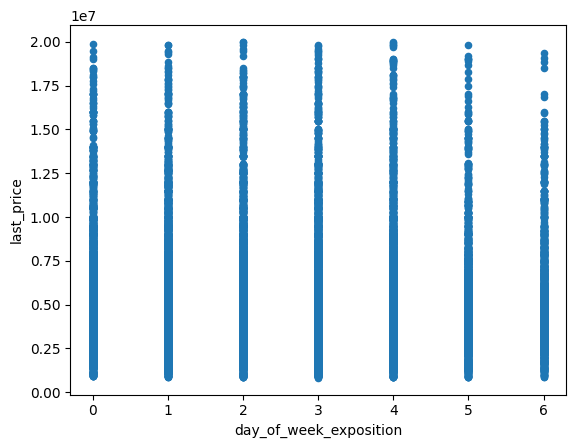

In [246]:
df.plot(x='day_of_week_exposition', y='last_price', kind='scatter');

<Axes: xlabel='day_of_week_exposition'>

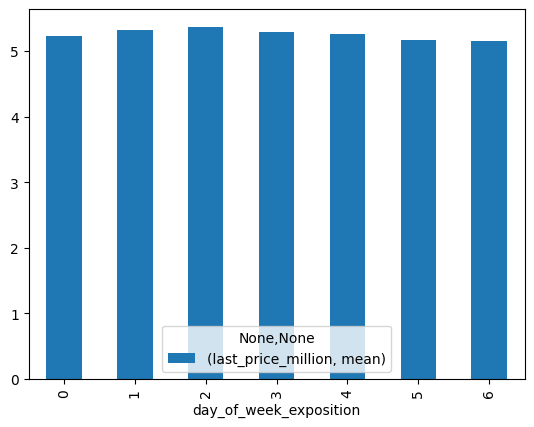

In [247]:
df.groupby('day_of_week_exposition').agg({'last_price_million': ['mean']}).plot(kind='bar')

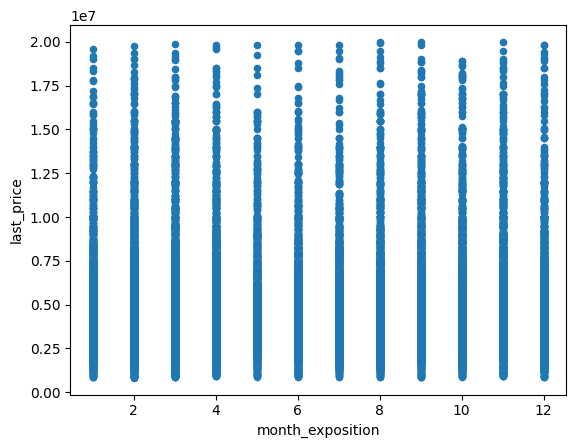

In [248]:
df.plot(x='month_exposition', y='last_price', kind='scatter');

<Axes: xlabel='month_exposition'>

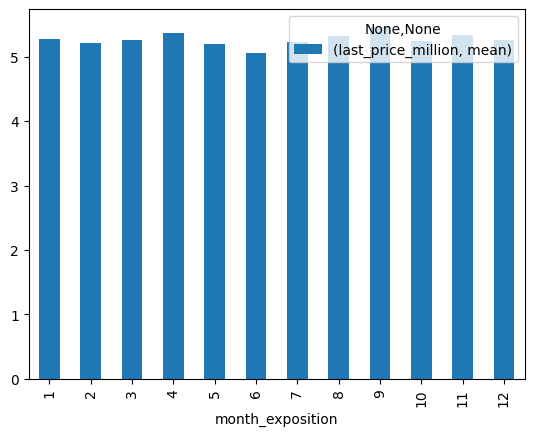

In [249]:
df.groupby('month_exposition').agg({'last_price_million': ['mean']}).plot(kind='bar')

<Axes: xlabel='year_exposition'>

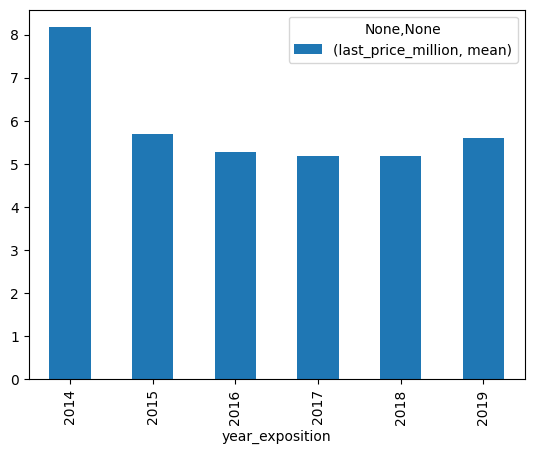

In [250]:
df.groupby('year_exposition').agg({'last_price_million': ['mean']}).plot(kind='bar')

- квартиры на 1 этаже в среднем дешевле
- дорогие квартиры реже всего выкладываются по воскресеньям
- в летние месяцы дорогие квартиры выкладываются реже
- существует положительная корреляция между площадью квартиры и стоимостью

<Axes: xlabel='year_exposition'>

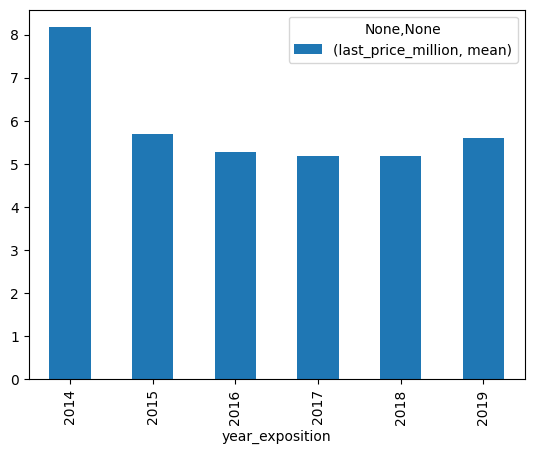

In [251]:
df.groupby('year_exposition').agg({'last_price_million': ['mean']}).plot(kind='bar')

In [252]:
(
    df.pivot_table(index='year_exposition',
                   columns='total_area_cat',
                   values='last_price_million',
                   aggfunc='count')
)

total_area_cat,"(18.799, 43.0]","(43.0, 60.0]","(60.0, 185.0]"
year_exposition,,,
2014,8,20,44
2015,238,264,356
2016,813,806,860
2017,2586,2478,2417
2018,2791,2572,2461
2019,836,948,837


In [253]:
(
    df.pivot_table(index='year_exposition',
                   columns='total_area_cat',
                   values='last_price_million',
                   aggfunc='mean')
)

total_area_cat,"(18.799, 43.0]","(43.0, 60.0]","(60.0, 185.0]"
year_exposition,,,
2014,4.225206,4.670412,10.477180
2015,3.399768,4.553718,8.056275
2016,3.404167,4.521524,7.772153
2017,3.380187,4.461866,7.824537
2018,3.479510,4.626781,7.715081
2019,3.730244,4.918174,8.212681


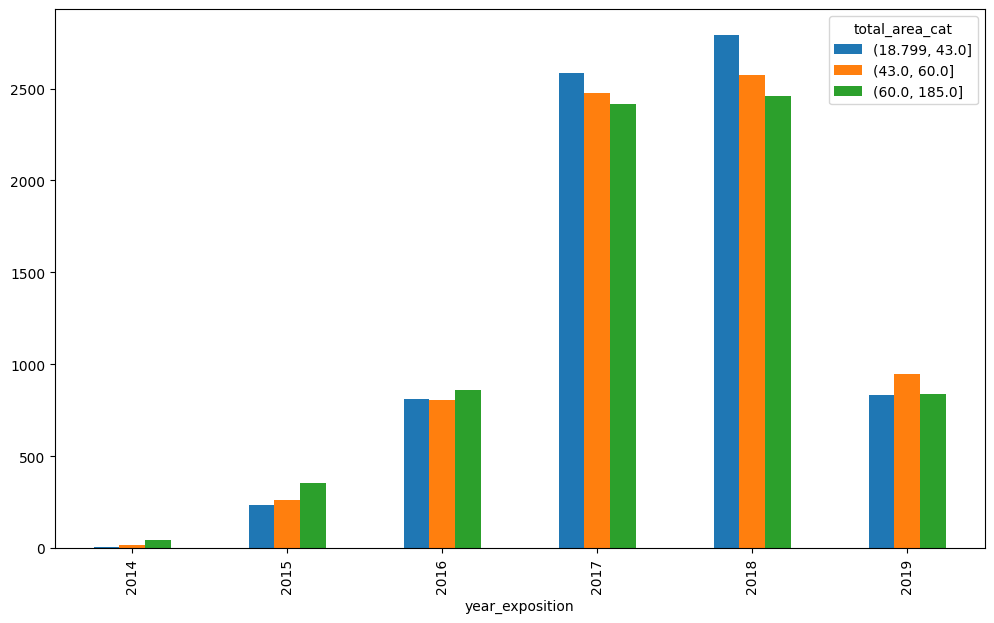

In [254]:
(
    df.pivot_table(index='year_exposition',
                   columns='total_area_cat',
                   values='last_price_million',
                   aggfunc='count')
).plot(kind='bar', figsize=(12,7));

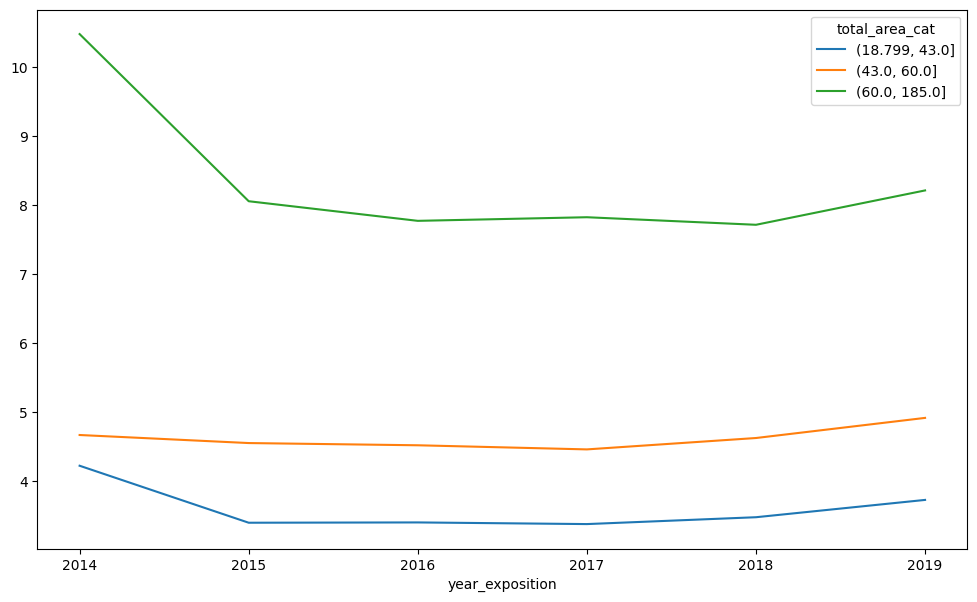

In [255]:
(
    df.pivot_table(index='year_exposition',
                   columns='total_area_cat',
                   values='last_price_million',
                   aggfunc='mean')
).plot(figsize=(12,7));

- средняя стоимость квадратного метра достаточно стабильна с течением времени в зависимости от категории общей площади квартиры. Наиболее сильный рост наблюдается за последний год в самой дорогой категории квартир от 60 млн.

In [256]:
(
    df.pivot_table(index='year_exposition',
                   columns='floor_type',
                   values='last_price_million',
                   aggfunc='mean')
)

floor_type,другой,первый,последний
year_exposition,,,
2014,8.484415,4.490206,9.198385
2015,6.007553,4.641868,5.189744
2016,5.489746,4.361837,5.132105
2017,5.386955,4.167062,4.900227
2018,5.407591,4.229052,4.850322
2019,5.820956,4.683373,5.092095


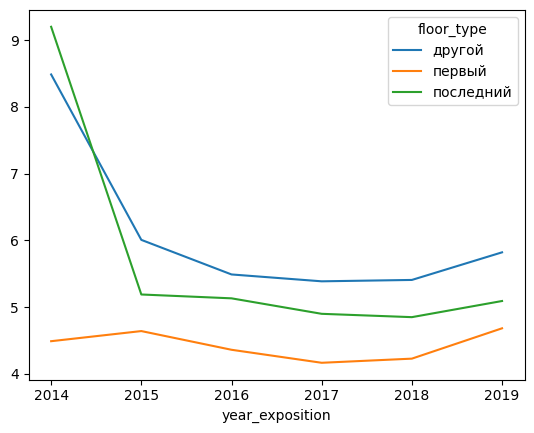

In [257]:
(
    df.pivot_table(index='year_exposition',
                   columns='floor_type',
                   values='last_price_million',
                   aggfunc='mean')
).plot();

- общая средняя цена квартир на 1 этаже выросла за последний анализируемый год, динамика роста выше, чем у квартир на других этажах

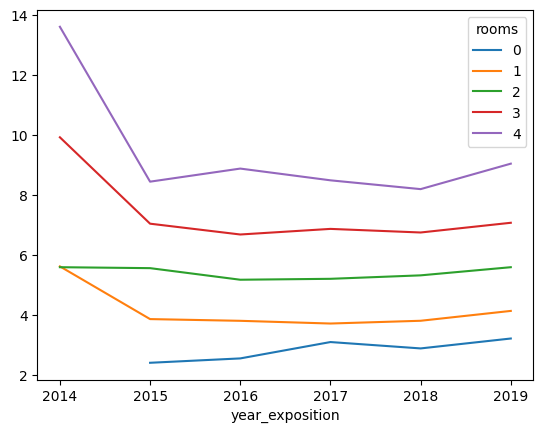

In [258]:
(
    df.pivot_table(index='year_exposition',
                   columns='rooms',
                   values='last_price_million',
                   aggfunc='mean')
).plot();

- квартиры с 4 комнатами показывают более сильную относительную динамику средней общей стоимости квартиры за последний год.

#### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [259]:
df_mean_price_meter = df.groupby('locality_name').agg({'meter_price': ['count', 'mean']}).reset_index()
df_mean_price_meter.columns = df_mean_price_meter.columns.map('_'.join)
df_mean_price_meter = df_mean_price_meter.sort_values(by='meter_price_count', ascending=False).head(10)
df_mean_price_meter['meter_price_mean'] = round(df_mean_price_meter['meter_price_mean'], 2)
df_mean_price_meter

,locality_name_,meter_price_count,meter_price_mean
175,Санкт-Петербург,13952,108494.52
117,Мурино,536,86306.05
84,Кудрово,447,95301.57
225,Шушары,416,78808.66
26,Всеволожск,389,67211.03
162,Пушкин,338,101857.37
72,Колпино,326,75434.68
32,Гатчина,297,68930.83
138,Парголово,280,89723.73
27,Выборг,223,58533.90


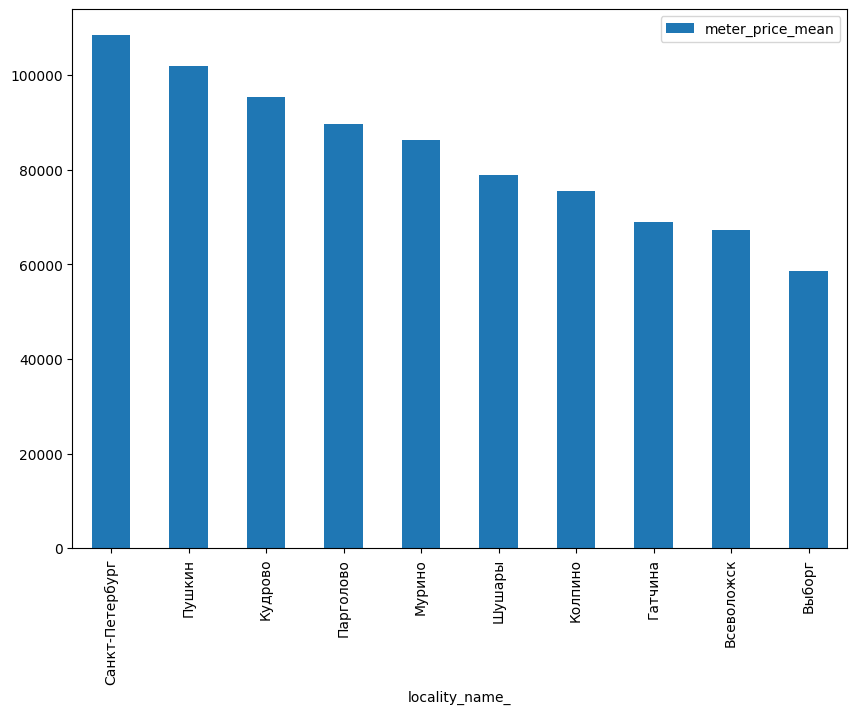

In [263]:
(df_mean_price_meter.sort_values(by='meter_price_mean', ascending=False).
    plot(x='locality_name_', y='meter_price_mean', kind='bar', figsize=(10,7)));

In [264]:
df_mean_price_meter[df_mean_price_meter['meter_price_mean'] == df_mean_price_meter['meter_price_mean'].min()]

,locality_name_,meter_price_count,meter_price_mean
27,Выборг,223,58533.9


In [265]:
df_mean_price_meter[df_mean_price_meter['meter_price_mean'] == df_mean_price_meter['meter_price_mean'].max()]

,locality_name_,meter_price_count,meter_price_mean
175,Санкт-Петербург,13952,108494.52


Важно отметить, что цифры выше усреднены за весь период анализа.

Ниже проверим распределение средней стоимости квадратного метра по топ-10 населённым пунктам по количеству объявлений в динамике за 5 лет (2014 в расчет не берём из-за одного месяца и небольшого количества объявлений в базе.

In [266]:
df_year_loc_meter_mean = (
    df[(df['locality_name'] == 'Санкт-Петербург') | (df['locality_name'] == 'Мурино') |
       (df['locality_name'] == 'Кудрово') | (df['locality_name'] == 'Шушары') |
       (df['locality_name'] == 'Всеволожск') | (df['locality_name'] == 'Пушкин') |
       (df['locality_name'] == 'Колпино') | (df['locality_name'] == 'Гатчина') |
       (df['locality_name'] == 'Парголово') | (df['locality_name'] == 'Выборг')]
    .pivot_table(index='year_exposition', columns='locality_name', values='meter_price', aggfunc='mean')
)
df_year_loc_meter_mean = df_year_loc_meter_mean[df_year_loc_meter_mean.index > 2014]
df_year_loc_meter_mean = round(df_year_loc_meter_mean, 2)
df_year_loc_meter_mean

locality_name,Всеволожск,Выборг,Гатчина,Колпино,Кудрово,Мурино,Парголово,Пушкин,Санкт-Петербург,Шушары
year_exposition,,,,,,,,,,
2015,70433.09,60517.42,68002.16,69625.84,90958.61,81887.03,89874.17,97824.18,105091.08,75207.77
2016,65665.17,57291.21,66877.56,76827.25,91613.64,86026.25,86002.88,104270.33,104840.62,77209.07
2017,65192.13,57841.67,65907.79,71447.67,93421.45,82317.73,88032.91,99165.37,105255.49,74493.19
2018,67786.62,56398.60,72114.35,77554.69,95856.34,88641.43,90615.09,103263.32,110250.38,81853.08
2019,71373.35,66541.97,72322.49,81681.93,110040.53,91247.25,98382.27,105131.76,116763.99,87464.26


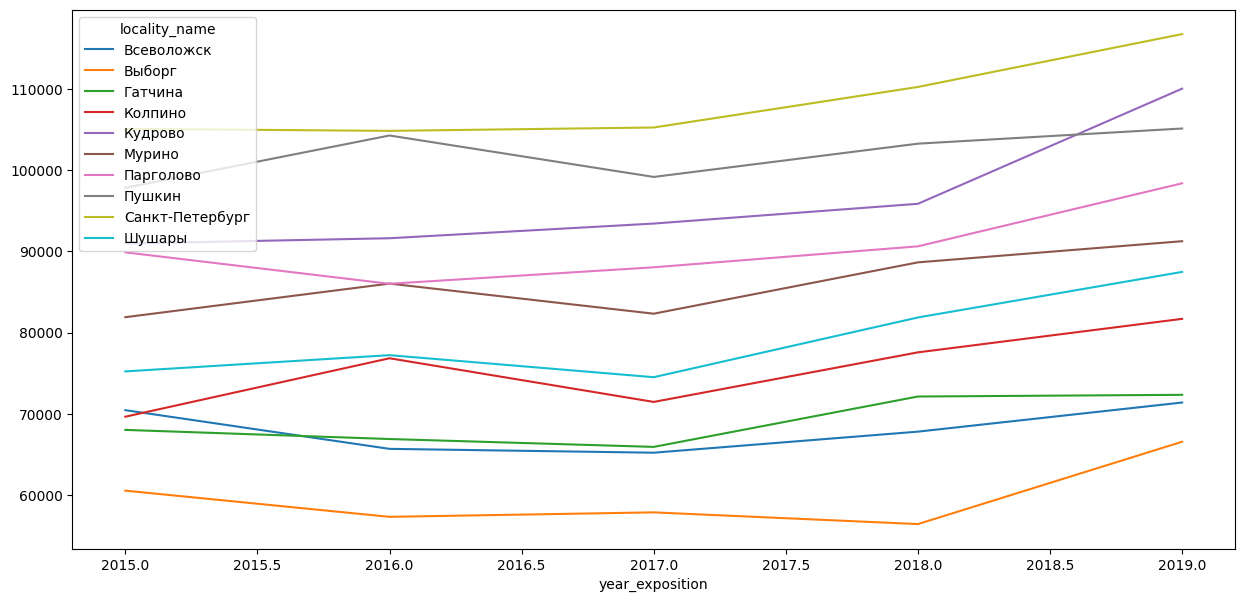

In [267]:
df_year_loc_meter_mean.plot(figsize=(15,7));

В среднем по всем населенных пунктам наблюдается положительная динамика повышения стоимости квадратного метра.  За последний год наибольшее относительное повышение наблюдается в Кудрово и Выборге. Отметим, что в Санкт-Петербурге по сравнению с областью скачки цен не столь выражены, что в большей степени обсловлено стабильно большим количеством объявлений (закон больших чисел)

#### Средняя цена километра

In [268]:
df_spb_mean_price_km = (
    df[df['locality_name'] == 'Санкт-Петербург'].groupby('cityCenters_nearest_km').
    agg({'meter_price': ['count', 'mean']}).reset_index()
)
df_spb_mean_price_km.columns = df_spb_mean_price_km.columns.map('_'.join)
df_spb_mean_price_km['meter_price_mean'] = df_spb_mean_price_km['meter_price_mean'].astype(int)
df_spb_mean_price_km

,cityCenters_nearest_km_,meter_price_count,meter_price_mean
0,0.0,8,110557
1,1.0,126,126691
2,2.0,187,124068
3,3.0,261,115449
4,4.0,507,123731
5,5.0,659,127879
6,6.0,467,129051
7,7.0,324,124432
8,8.0,514,119862
9,9.0,547,110411


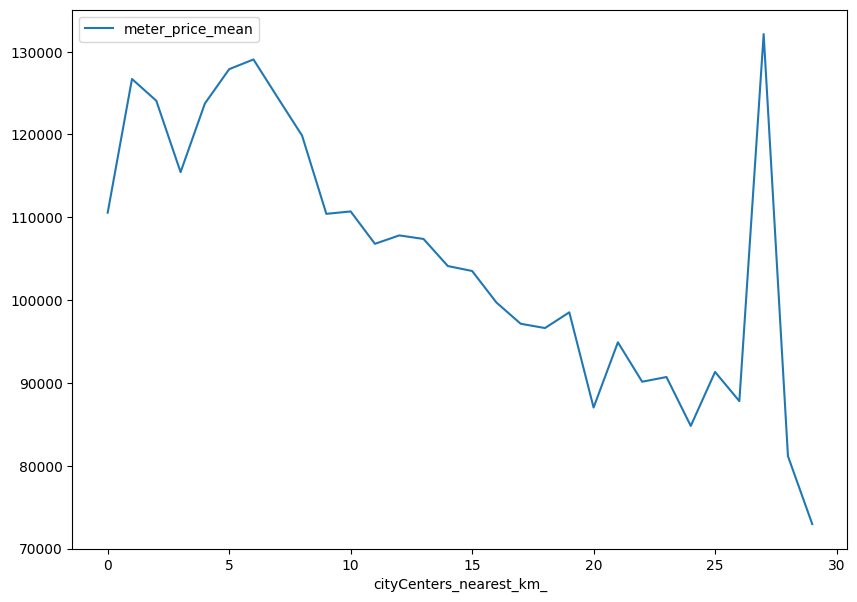

In [269]:
df_spb_mean_price_km.plot(x='cityCenters_nearest_km_', y='meter_price_mean', figsize=(10,7));

- в целом мы видим отрицательную динамику - с увеличением удаленности от центра стоимость квартир снижается
- существует провал на 3 км и повышение средней стоимости квадратного метра на 6 км (можно предположить, что это Крестовский остров)

Есть и несколько аномалий:

- в самом центре (о км) средняя стоимость квадратного метра ниже первого километра
- наибольшая средняя стоимость квадратного метра на 27 километре - 132 т.р.

Возможно, дело в количестве объявлений, визуализируем их:

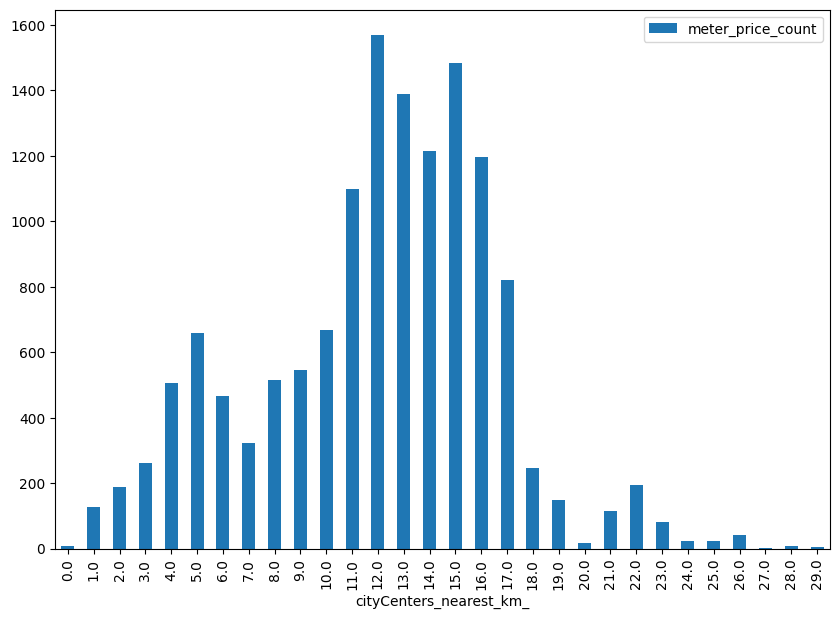

In [270]:
df_spb_mean_price_km.plot(x='cityCenters_nearest_km_', y='meter_price_count', figsize=(10,7), kind='bar');

In [271]:
df_spb_mean_price_km['meter_price_count'].mean()

465.06666666666666

Да, как мы и предполагали на 0 и 27 километре только 8 и 2 объвлений соответственно (при среднем количестве - 465 объявлений на километр) - этого количества недостаточно, чтобы делать какие-то выводы.

Построим новый график с исключением недостаточного количества объявлений.

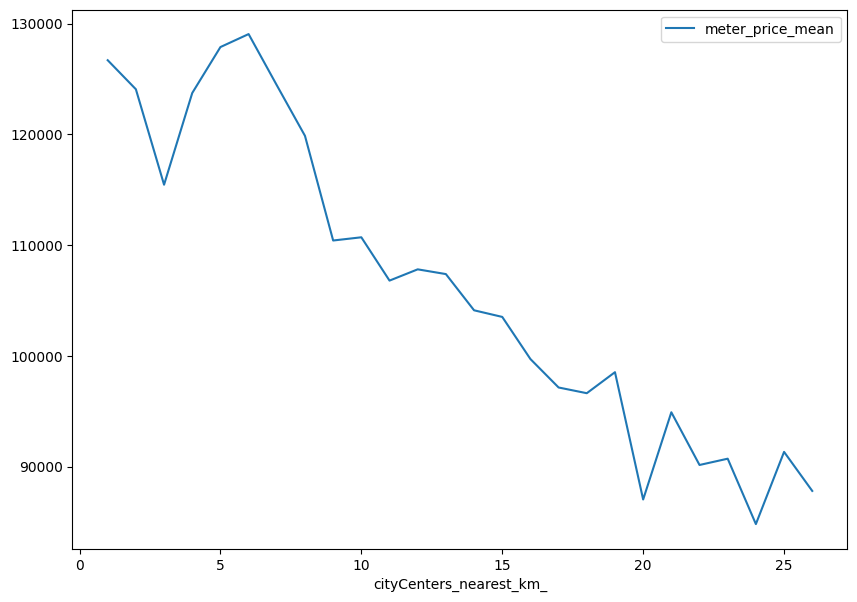

In [272]:
(df_spb_mean_price_km[(df_spb_mean_price_km['cityCenters_nearest_km_'] > 0) &
                         (df_spb_mean_price_km['cityCenters_nearest_km_'] < 27)]
    .plot(x='cityCenters_nearest_km_', y='meter_price_mean', figsize=(10,7)));

Посмотрим также на объявления на 27 км

In [273]:
df[(df['cityCenters_nearest_km'] == 27.0) & (df['locality_name'] == 'Санкт-Петербург')]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition,cityCenters_nearest_cat,meter_price,day_of_week_exposition,month_exposition,year_exposition,floor_type,cityCenters_nearest_km,last_price_million,last_price_million_cat,total_area_cat,days_exposition_cat
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,False,25.0,0,Санкт-Петербург,23888.0,27313.0,1.0,0.0,128.0,"(25796.0, 65968.0]",193918.918919,1,11,2017,другой,27.0,14.35,"(6.9, 19.999]","(60.0, 185.0]","(121, 300]"
5961,6,2250000.0,32.0,2018-02-27,1,2.60,2,16.5,2,False,False,7.0,0,Санкт-Петербург,24006.0,27431.0,0.0,0.0,178.0,"(25796.0, 65968.0]",70312.500000,1,2,2018,последний,27.0,2.25,"(0.819, 3.15]","(18.799, 43.0]","(121, 300]"


Из двух объявлений одно сильно выбивается по стоимости квадратного метра, возможно в квартире дорогой ремонт.

И также подробнее рассмотрим пик и провал в центре (количество объявлений там можно считать достаточным):

In [274]:
df_3km = (
    df[(df['cityCenters_nearest_km'] == 3.0) & (df['locality_name'] == 'Санкт-Петербург')].
    groupby('floor_type').agg({'meter_price': ['count', 'mean']}).reset_index()
)

df_3km.columns = df_3km.columns.map('_'.join)
df_3km['meter_price_percent'] = round(df_3km['meter_price_count'] / df_3km['meter_price_count'].sum() * 100, 2)
df_3km

,floor_type_,meter_price_count,meter_price_mean,meter_price_percent
0,другой,156,118573.530425,59.77
1,первый,42,104408.705355,16.09
2,последний,63,115074.619568,24.14


In [275]:
df_6km = (
    df[(df['cityCenters_nearest_km'] == 6.0) & (df['locality_name'] == 'Санкт-Петербург')].
    groupby('floor_type').agg({'meter_price': ['count', 'mean']}).reset_index()
)

df_6km.columns = df_6km.columns.map('_'.join)
df_6km['meter_price_percent'] = round(df_6km['meter_price_count'] / df_6km['meter_price_count'].sum() * 100, 2)
df_6km

,floor_type_,meter_price_count,meter_price_mean,meter_price_percent
0,другой,348,133586.012904,74.52
1,первый,57,115851.985681,12.21
2,последний,62,115735.635573,13.28


Мы видим, что на последних этажах квартир на 3 км и на 6 км средняя стоимость квадратного метра равна 115 т.р.

В то время как на 1 этаже ближе к центру стоимость квадратного метра ниже стоимости квадратного метра квартир на 1 этаже на 6 км. (На 6 км средний метр на квартир на первом и последнем этажах равен 115 т.р.)

На 3 км квартиры на "других" этажах в среднем по метру дороже последнего этажа на 3 тысячи, в то время как квартиры на "других" этажах на 6 км увеличены в стоимости метра в сравнении с первым и последним этажом значительно - на 18 тысяч.

То есть пик на 6 км обусловлен квартирами на "других" этажах.

Посмотрим также на среднюю стоимость квадратного метра по топ-10 городам в разбике по типам этажей.

In [276]:
pivot_loc_meter_price = (
    df[(df['locality_name'] == 'Санкт-Петербург') | (df['locality_name'] == 'Мурино') |
       (df['locality_name'] == 'Кудрово') | (df['locality_name'] == 'Шушары') |
       (df['locality_name'] == 'Всеволожск') | (df['locality_name'] == 'Пушкин') |
       (df['locality_name'] == 'Колпино') | (df['locality_name'] == 'Гатчина') |
       (df['locality_name'] == 'Парголово') | (df['locality_name'] == 'Выборг')]
    .pivot_table(index='locality_name', columns='floor_type', values = 'meter_price', aggfunc='mean')
    .reset_index()
    .sort_values(by='другой', ascending=False)
)
pivot_loc_meter_price

floor_type,locality_name,другой,первый,последний
8,Санкт-Петербург,110370.455741,96966.673411,106138.270873
7,Пушкин,101783.829442,99025.334563,105159.754933
4,Кудрово,95170.150943,96272.312329,97005.535017
6,Парголово,90758.380597,78656.019252,76050.349543
5,Мурино,86643.566099,80788.834456,84091.065870
9,Шушары,79616.694881,75189.673358,77594.136554
3,Колпино,76446.766235,71486.506669,75275.340872
2,Гатчина,71448.291249,65040.983518,66292.686602
0,Всеволожск,69274.291524,62280.039054,64028.336049
1,Выборг,60000.074902,56721.085453,55803.475737


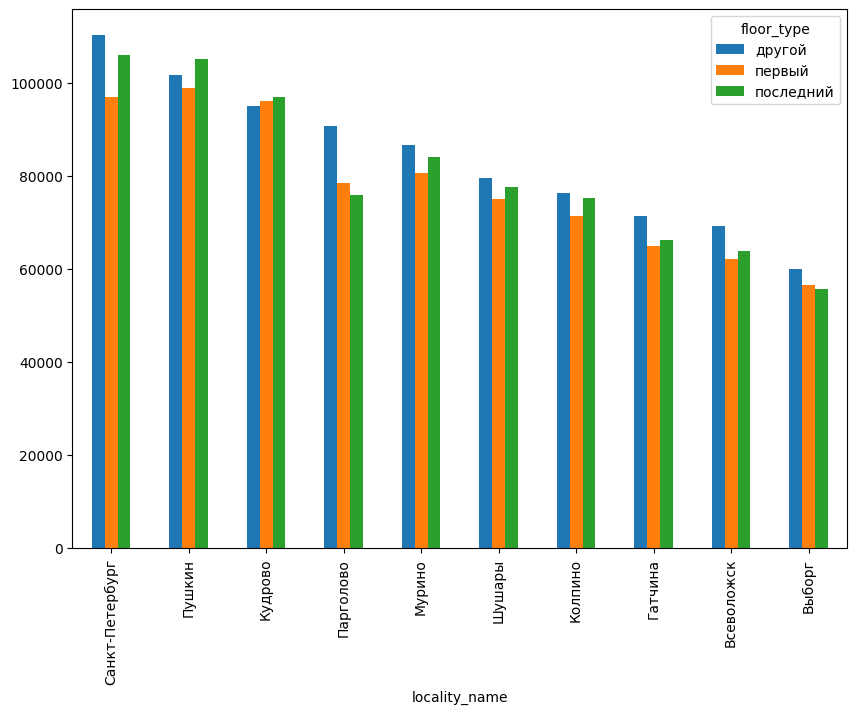

In [277]:
pivot_loc_meter_price.plot(x='locality_name', kind='bar', figsize=(10,7));

- в среднем стоимость квадратного метра квартир на "других" этажах всегда выше, дешевле всего метр у квартир на 1 этаже
- в Пушкине и Кудрово в среднем самый дорогой метр у квартир на последнем этаже. В Кудрово метр квартир на "других" этажах дешевле первого и последнего

### Общий вывод

Цель работы - поиск интересных особенностей и зависимостей, которые существуют на рынке недвижимости.
Перед самим EDA была проведена предобработка данных:
- обработаны пропуски
- обработаны неявные дубликаты
- добавлены новые столбцы для анализа, в том числе категории для количественных признаков

В процессе анализа выяснилось, что бОльшая доля в пропусках - пропуски в картографических данных.

Выводы по исследованию:
- среди объявлений существуют большие выбросы в ценах квартир (дорогие квартиры)
- площадь квартир (общая, жилая, площадь кухни) имеет сильные выбросы больших значений
- количество комнат обычно до 5, но встречаются объявления со значениями до 19
- высота потолков выше 5 метров всего в 15 объявлениях
- количество объявлений со временем увеличивается
- большинство квартир находится в радиусе 20 км от центра города
- распределение этажа квартиры и общего количества этажей в доме похоже на распределение Пуассона, искаженное вправо
- есть жирный хвост у распределения количества дней размещения объявления

В большей степени на стоимость квартиры влияют:
- площадь квартиры (общая, жилая, площадь кухни)
- количество комнат
- высота потолков
- первые этажи меньше по стоимости, последний этаж в среднем дороже других


- быстрее всего продаются квартиры близкие к центру и минимальные по цене
- дольше продаются квартиры в дорогом сегменте на первых и последних этажах
- квартиры меньшей площади продаются быстрее


- квартиры с 4 комнатами показывают более сильную относительную динамику средней общей стоимости квартиры за последний год


- средняя стоимость квадратного метра достаточно стабильна с течением времени в зависимости от категории общей площади квартиры. Наиболее сильный рост наблюдается за последний год в самой дорогой категории квартир от 60 млн.


- общая средняя цена квартир на 1 этаже выросла за последний анализируемый год, динамика роста выше, чем у квартир на других этажах

- медиана площади - 50 кв метров, медиана жилой площади - 30 метров, медиана площади кухни - 9 метров

- больше всего квартир с 1 по 5 этаж, это связано с общим количеством этажей

- у большинства квартир отсутствуют парки в пределах 3 км

- преимущественно объявления выкладываются в будни

- в целом за все время меньше всего объявлений выкладывается в мае, январе и декабре, больше всего в феврале после чего наблюдается спад до минимального в мае и с летних месяцев снова начинает рост до ноября включительно

- дорогие квартиры реже всего выкладываются по воскресеньям

- в летние месяцы дорогие квартиры выкладываются реже

- долго продается историческая застройка (старый фонд) - в максимальной близости к центру и максимальными ценами.
- 50% квартир стоимостью до 3.15 млн и в близости до 4.8 км к центру продается в срок до 44 дней
- среди этой же категории продаж до 44 дней меньше всего продаж самый отдаленных от центра и дорогих квартир


- среди 10 населённых пунктов с наибольшим числом объявлений средняя цена одного квадратного метра выше всего в Санкт-Петербурге - 108 т.р., ниже всего в Выборге - 58 т.р. Но тут важно отметить, что цифры просчитаны в среднем за 6 лет.

- если смотеть на цифры в динамике по годам - среднем по всем населенных пунктам наблюдается положительная динамика повышения стоимости квадратного метра.  За последний анализируемый год наибольшее относительное повышение наблюдается в Кудрово и Выборге. Отметим, что в Санкт-Петербурге по сравнению с областью скачки цен не столь выражены, что в большей степени обсловлено стабильно большим количеством объявлений (закон больших чисел)

Зависимость стоимости объектов от расстояния до центра города:
- в целом динамика отрицательная - с увеличением удаленности от центра стоимость квартир снижается
- существует провал на 3 км и повышение средней стоимости квадратного метра на 6 км (можно предположить, что это Крестовский остров, где особенно котируются квартиры на "других" этажах)


- в среднем стоимость квадратного метра квартир на "других" этажах всегда выше, дешевле всего метр у квартир на 1 этаже
- в Пушкине и Кудрово в среднем самый дорогой метр у квартир на последнем этаже. В Кудрово метр квартир на "других" этажах дешевле первого и последнего

In [ ]:
# check
import seaborn as sns
import matplotlib.pyplot as plt

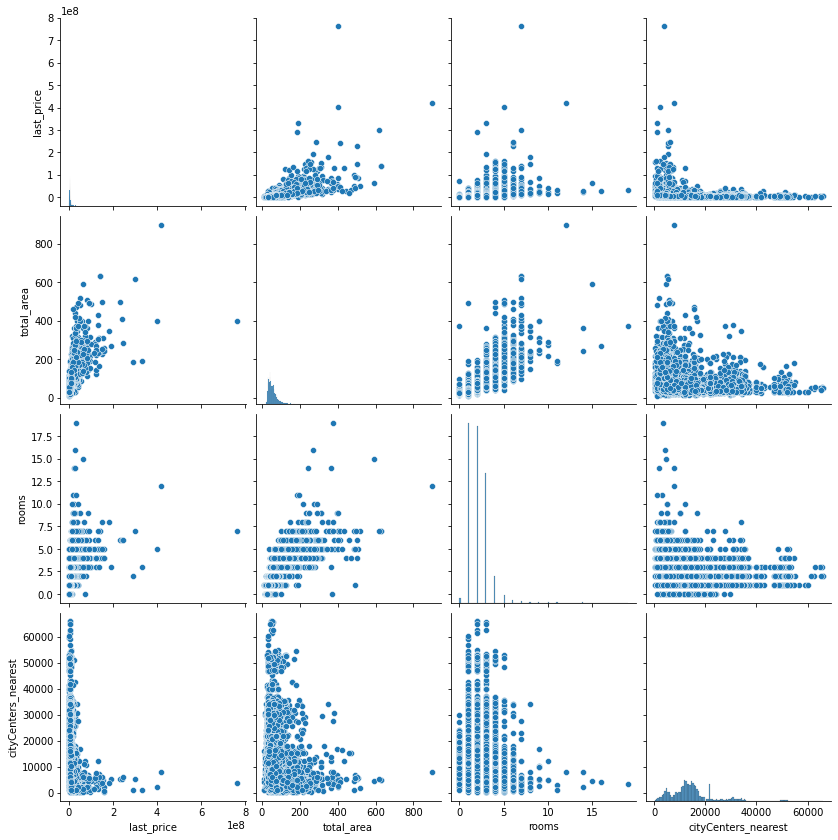

In [ ]:
# check
sns.pairplot(data[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']])
plt.gcf().set_size_inches(12,12);


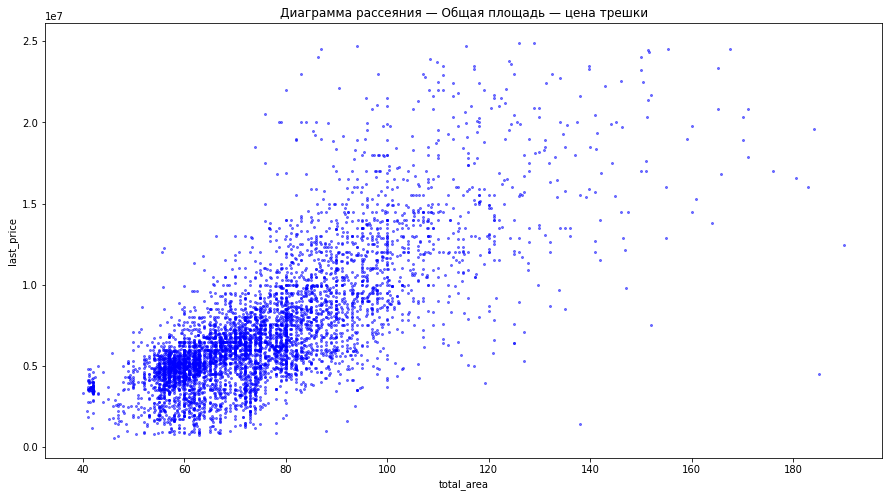

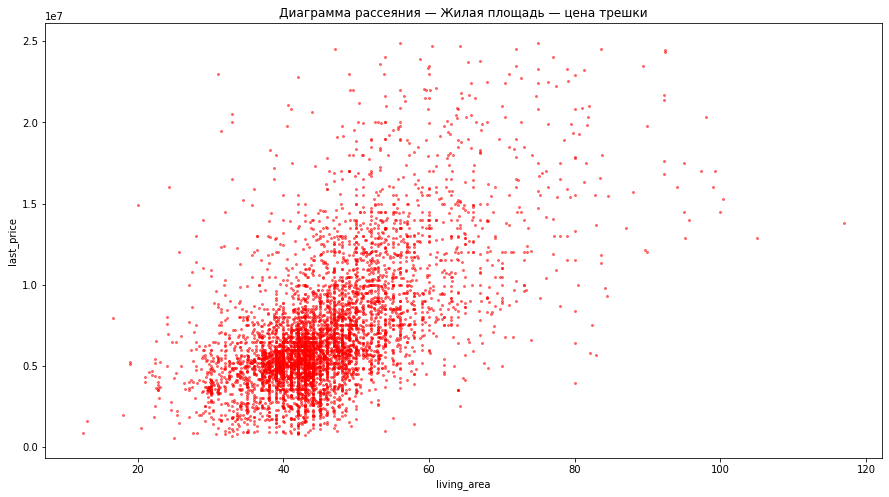

In [ ]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

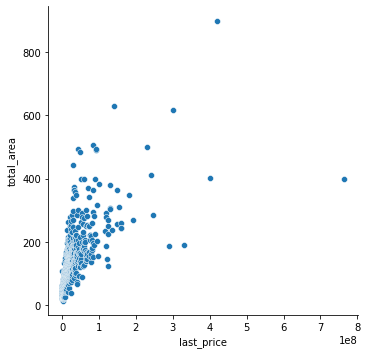

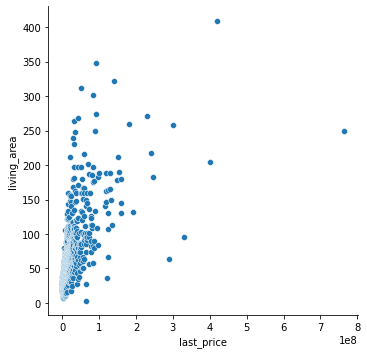

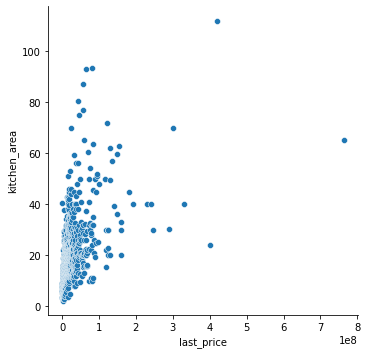

In [ ]:
# check
price_pivot_area = data.pivot_table(index='last_price', values=([
    'total_area', 'living_area', 'kitchen_area']), aggfunc='median')
price_pivot_area = price_pivot_area.reset_index()
# Посмотрим на диаграммы рассеяния для столбцов 'total_area', 'living_area', 'kitchen_area'.
for row in ['total_area', 'living_area', 'kitchen_area']:
    sns.relplot(data=price_pivot_area, x='last_price', y=row, kind='scatter')